In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os

print('complete')

complete


In [2]:
def normalize(data):
    
    data_mean = np.nanmean(data, axis = 0)
    data_std = np.nanstd(data, axis = 0)
    data_norm = (data - data_mean)/data_std
    
    return data_norm

In [3]:
# Extract variables

PATH_SOURCE = "/home/jbassham/jack/data/weddell/1992_2020"
PATH_DEST = PATH_SOURCE

In [4]:
fnam = "motion_ppv4_latlon_sh_1992_2020.npz"

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v'] # meridional ice velocity
r = data['error']
lat = data['lat']
lon = data['lon']
time = data['time']

In [5]:
fnam = "con_nimbus7_latlon_sh_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic']# zonal ice velocity

# Mask ice concentration
ic_raw = np.round(ic * 250)

# Mask 
# 251 pole hole
# 252 unused data
# 253 coastline
# 254 land
ic = np.where((ic_raw == 251) | (ic_raw == 252) | (ic_raw == 253) | (ic_raw == 254), np.nan, ic)

In [6]:
fnam = "wind_JRA55_latlon_global_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
uw = data['u']
vw = data['v']

In [7]:
# Shift present day parameters forward one day, for one point Middle Weddell
uit = ui[1:,:,:]
vit = vi[1:,:,:]
uwt = uw[1:,:,:]
vwt = vw[1:,:,:]
ict = ic[1:,:,:]
tt = time[1:]
rt = r[1:,:,:]

# Remove last day from previous day parameters
icy = ic[:-1,:,:]
ty = time[:-1]

In [8]:
# Filter points with ice error greater than 999 and 0 concentration ice motion
# Create mask
mask = (ict == 0) | (np.isnan(ict)) | (rt >= 999) | (rt <= -999)

# NaN out points with above condition
uit = np.where(mask, np.nan, uit) 
vit = np.where(mask, np.nan, vit)
rt = np.where(mask, np.nan, rt)
uwt = np.where(mask, np.nan, uwt)
vwt = np.where(mask, np.nan, vwt)
icy = np.where(mask, np.nan, icy)

/home/jbassham/miniconda3/envs/seaice/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


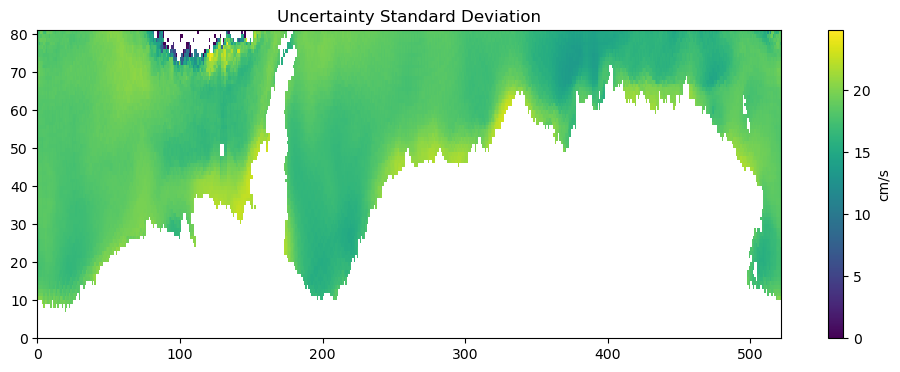

/tmp/ipykernel_2236790/88492183.py:14: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(rt, axis = 0)


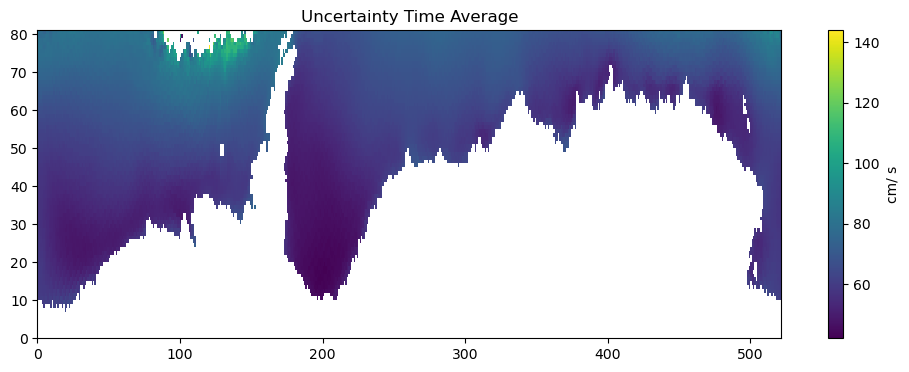

/tmp/ipykernel_2236790/345893780.py:3: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis = 0)
/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std
/tmp/ipykernel_2236790/88492183.py:25: RuntimeWarning: Mean of empty slice
  mean_norm = np.nanmean(normalize(rt), axis = 0)


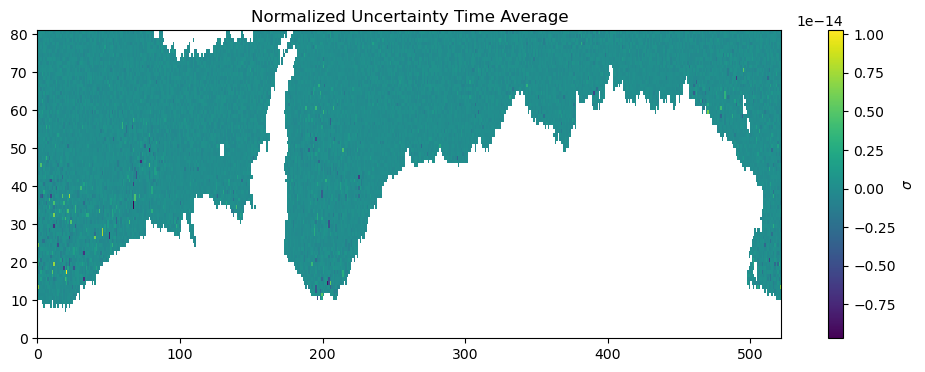

In [9]:
# CAUTION: Is normalizing uncertainty with eroneous values causing problems (if standard deviation big)?

std = np.nanstd(rt, axis = 0)
vmin = np.nanmin(std)
vmax = np.nanmax(std)

plt.figure(figsize = (12, 4))
plt.pcolormesh(std, vmin = vmin, vmax = vmax)
cb = plt.colorbar()
cb.set_label('cm/s')
plt.title(r'Uncertainty Standard Deviation')
plt.show()

mean = np.nanmean(rt, axis = 0)
vmin = np.nanmin(mean)
vmax = np.nanmax(mean)

plt.figure(figsize = (12, 4))
plt.pcolormesh(mean, vmin = vmin, vmax = vmax)
cb = plt.colorbar()
cb.set_label('cm/ s')
plt.title(r'Uncertainty Time Average')
plt.show()

mean_norm = np.nanmean(normalize(rt), axis = 0)
vmin = np.nanmin(mean_norm)
vmax = np.nanmax(mean_norm)

plt.figure(figsize = (12, 4))
plt.pcolormesh(mean_norm, vmin = vmin, vmax = vmax)
cb = plt.colorbar()
cb.set_label(r'$ \sigma $')
plt.title(r'Normalized Uncertainty Time Average')
plt.show()

# # Flag uncerainty values less than 0.01 cm/s, greater than 1000 cm/s as 9999
# rt_n_flag = (np.where((rt <= 0.01 | rt >= 1000), 9999, rt))

In [10]:
def weighted_skill(fit, true, r):
    
    skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)
    
    return skill_weighted

In [11]:
def skill(fit, true):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

In [64]:
def return_plot_skill(fit, true, r, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    # Calculate skill of complex output (the ice velocity vector)
    skill_vector = skill(fit, true)
    # NOTE: Variance of complex input returned as Var(z)=E[(z−E[z])**2
    # so a real number is returned that represents the spread in both u and v components of the vector
    
    skill_u = skill(np.real(fit), np.real(true))
    skill_v = skill(np.imag(fit), np.imag(true))
    
    data = [skill_vector, skill_u, skill_v]
    titles = ['vector', 'u', 'v']
    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), constrained_layout=True)
    
    for i in range(3):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Skill {model}')
    plt.show()
    
    weighted_skill_vector = weighted_skill(fit, true, r)
    weighted_skill_u = weighted_skill(np.real(fit), np.real(true), r)
    weighted_skill_v = weighted_skill(np.imag(fit), np.imag(true), r)
    
    data = [weighted_skill_vector, weighted_skill_u, weighted_skill_v]
    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), constrained_layout=True)
    
    for i in range(3):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Weighted Skill')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Weighted Skill {model}')
    plt.show()
    
    var_true_vector = np.nanvar(true, axis = 0)
    var_true_u = np.nanvar(np.real(true), axis = 0)
    var_true_v = np.nanvar(np.imag(true), axis = 0)
    
    data = [var_true_vector, var_true_u, var_true_v]
    titles = [r'vector', r'u', r'v']
    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), constrained_layout=True)
    
    for i in range(3):
        pcm = axs[i].pcolormesh(lon, lat, data[i])
        fig.colorbar(pcm, ax=axs[i], label='')
        axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
        
    fig.suptitle(f'Variance {model}')
    plt.show()
    
    return skill_vector, skill_u, skill_v, weighted_skill_vector, weighted_skill_u, weighted_skill_v

### Unweighted LR

In [13]:
def lr_gridwise(uit, vit, uwt, vwt, icy):
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Find model paremeters
                    m = (np.linalg.inv(G.T @ G)) @ G.T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

In [14]:
m, fit, true = lr_gridwise(uit, vit, uwt, vwt, icy)

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


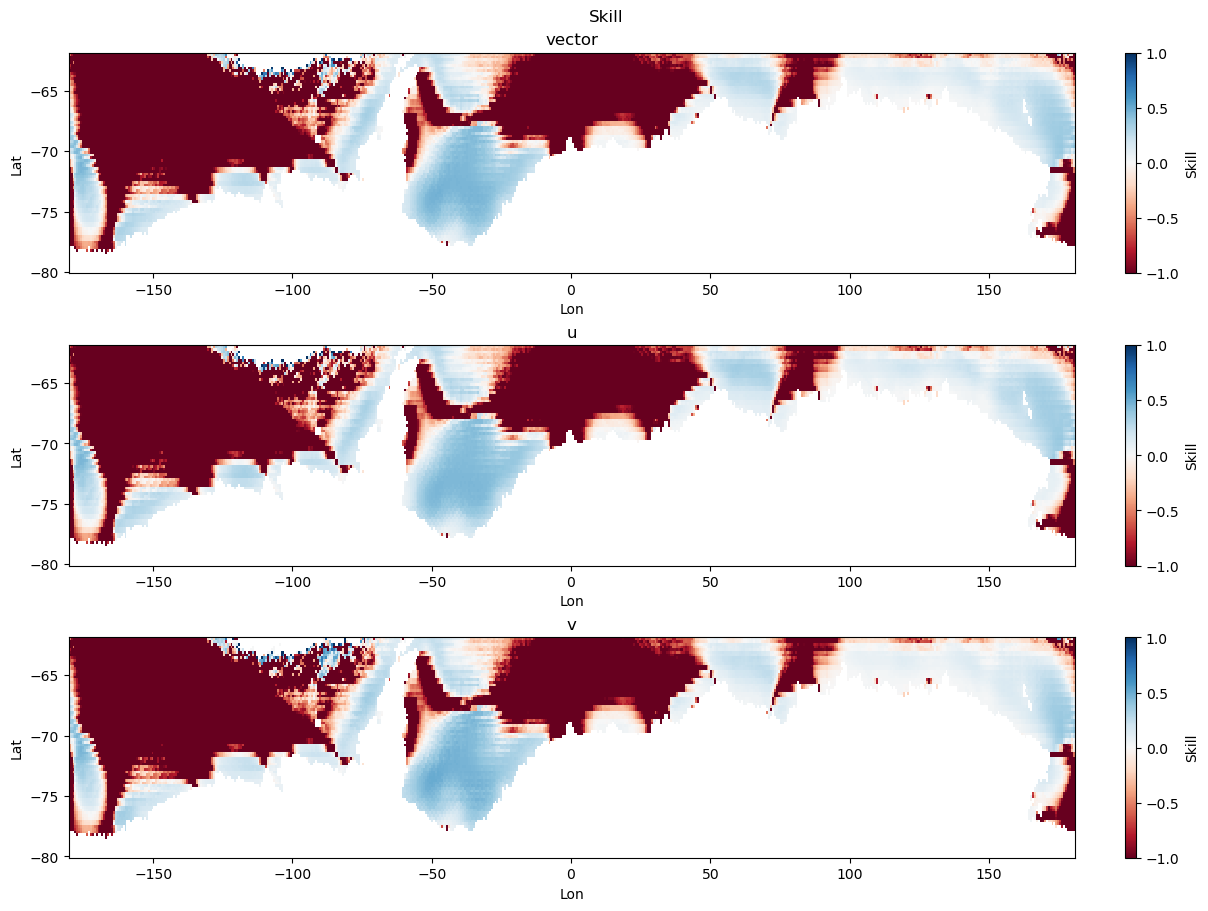

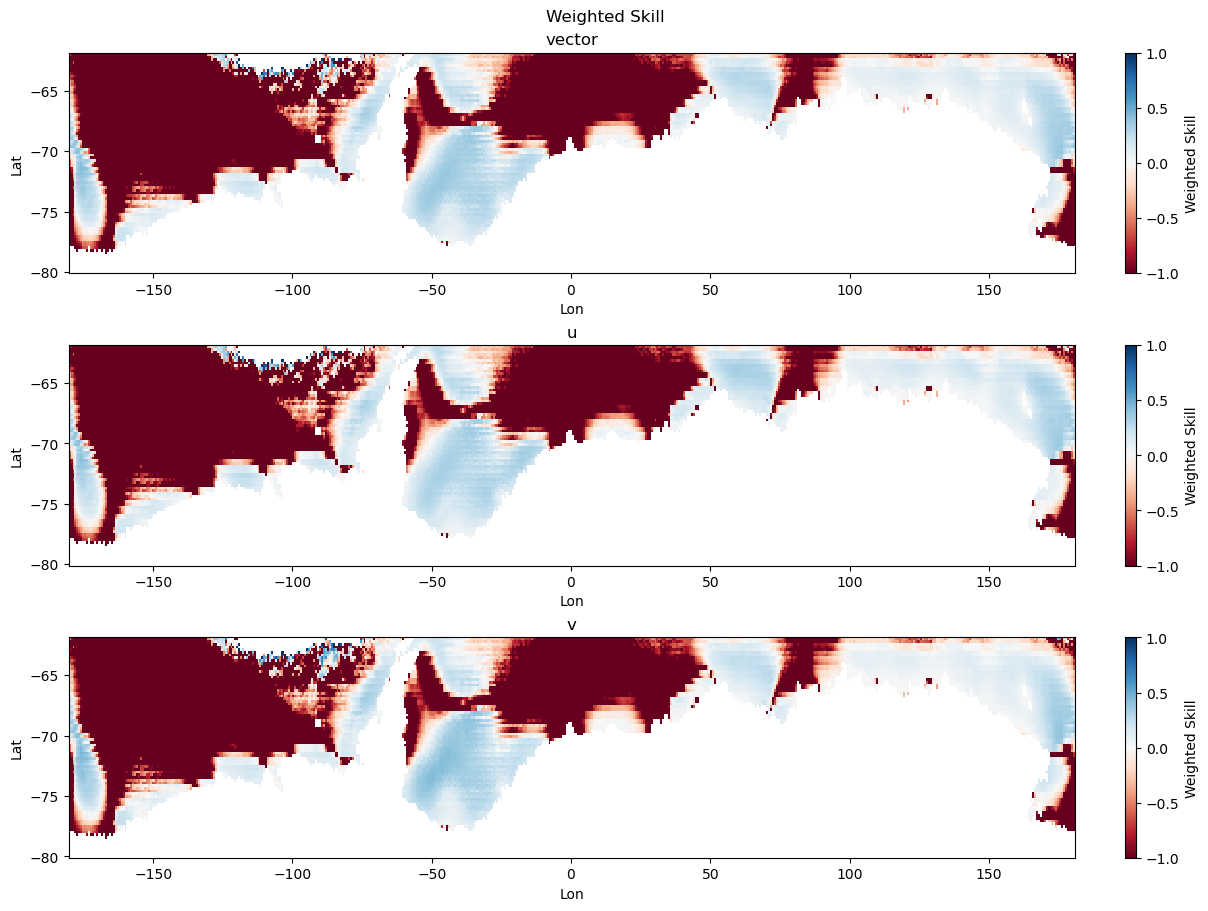

/tmp/ipykernel_2236790/1079227739.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_vector = np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/1079227739.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_u = np.nanvar(np.real(true), axis = 0)


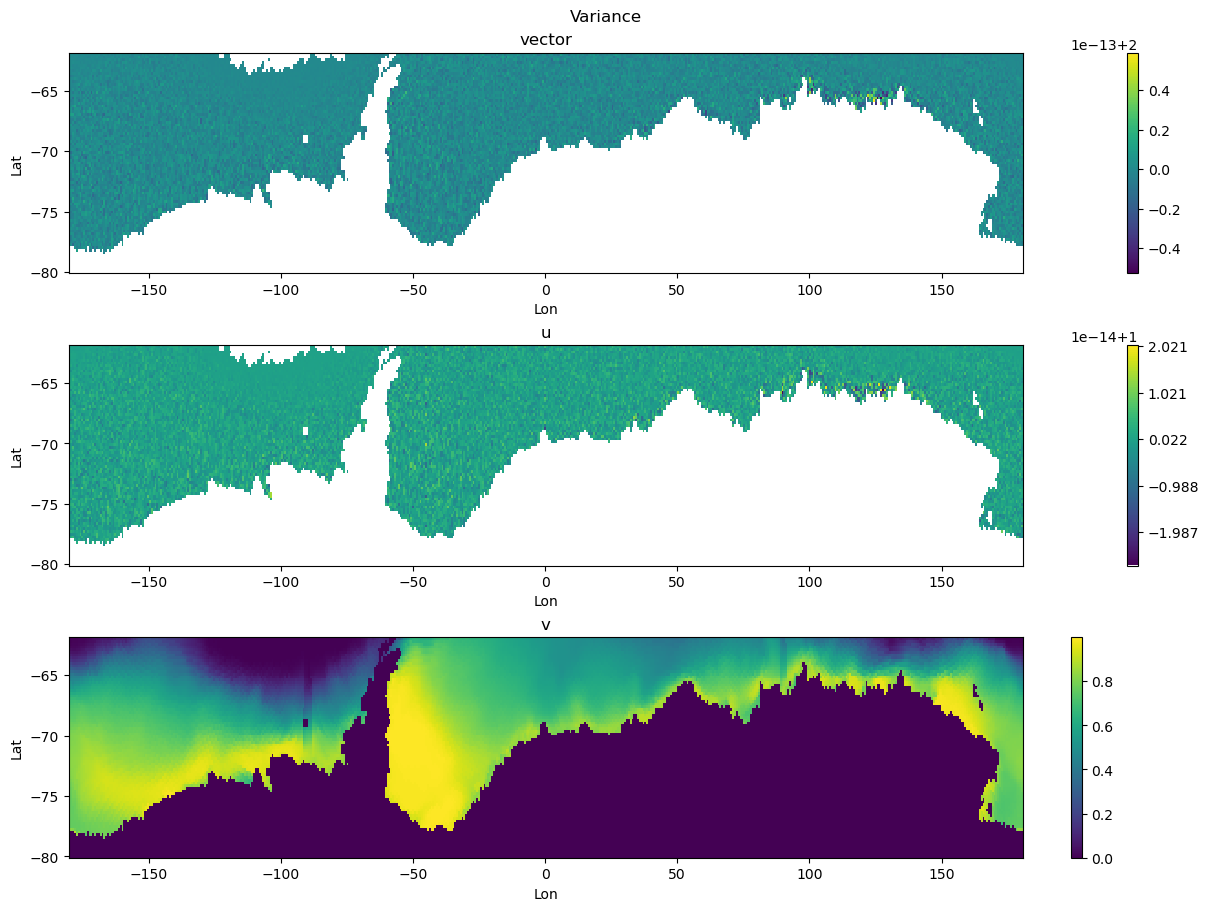

(array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.59669423, -1.08335628, -1.12843026, ..., -0.77532721,
         -0.45788014, -1.60145193],
        [-1.24092702, -4.00102839, -2.64518069, ..., -1.5925884 ,
         -1.77840611, -6.00396556],
        [-0.56505051, -0.86635059, -2.91464572, ..., -0.0748947 ,
         -0.14546174, -1.04224177]]),
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.59398219, -1.00362559, -1.01838587, ..., -

In [15]:
return_plot_skill(fit, true, rt)

### Debug Unweighted LR and Skill

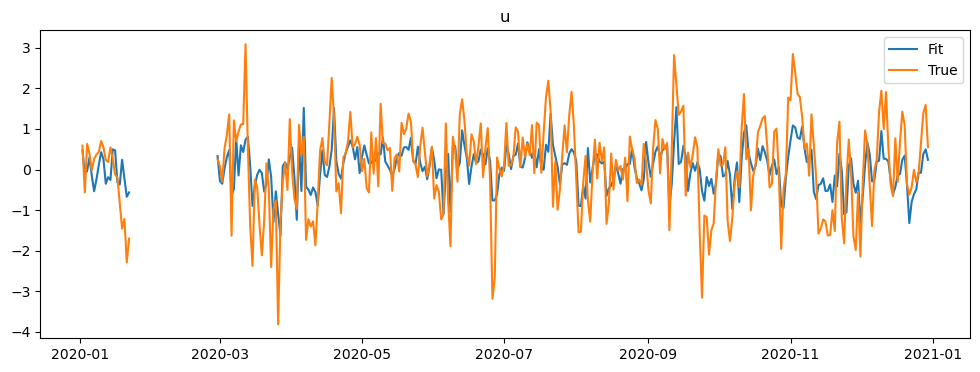

In [16]:
iy, ix = 40, 200 # Middle Weddell

plt.figure(figsize = (12,4))

plt.plot(tt[-365:], np.real(fit[-365:, iy, ix]), label = 'Fit')
plt.plot(tt[-365:], np.real(true[-365:, iy, ix]), label = 'True')
plt.legend()
plt.title('u')
plt.show()

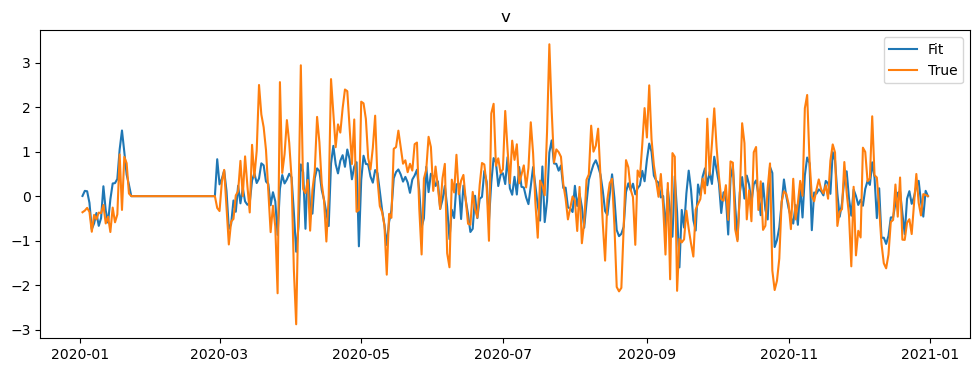

In [17]:
iy, ix = 40, 200 # Middle Weddell

plt.figure(figsize = (12,4))

plt.plot(tt[-365:], np.imag(fit[-365:, iy, ix]), label = 'Fit')
plt.plot(tt[-365:], np.imag(true[-365:, iy, ix]), label = 'True')
plt.legend()
plt.title('v')
plt.show()

/tmp/ipykernel_2236790/4024110757.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sk = 1 - np.nanvar(np.real(fit) - np.real(true), axis = 0) / np.nanvar(np.real(true), axis = 0)
/tmp/ipykernel_2236790/4024110757.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sk_weighted = 1 - np.nanvar((np.real(fit) - np.real(true)) / rt, axis = 0) / np.nanvar(np.real(true) / rt, axis = 0)


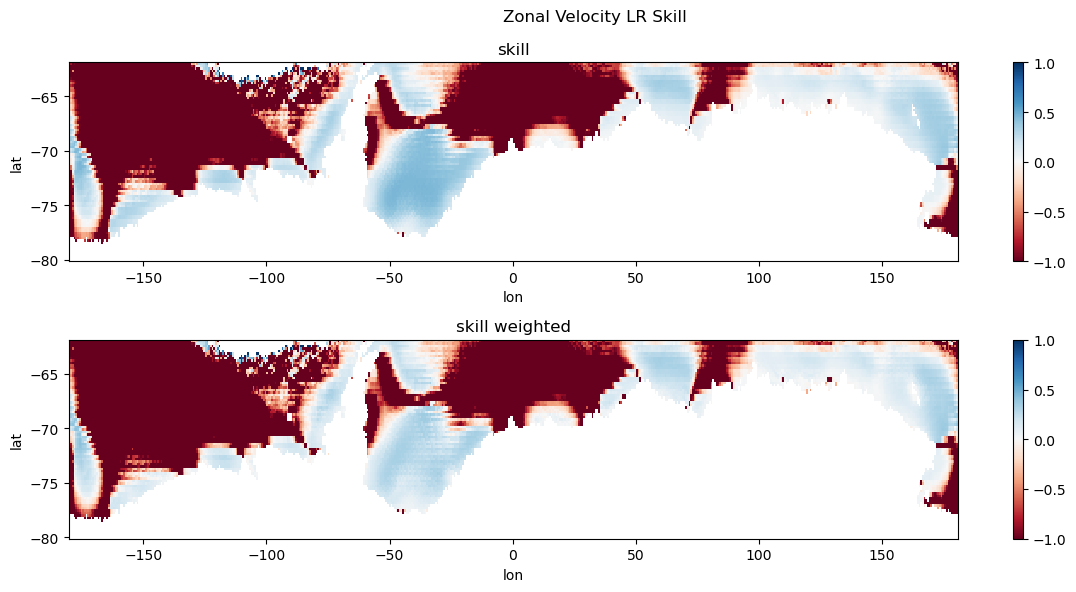

In [18]:
sk = 1 - np.nanvar(np.real(fit) - np.real(true), axis = 0) / np.nanvar(np.real(true), axis = 0)
sk_weighted = 1 - np.nanvar((np.real(fit) - np.real(true)) / rt, axis = 0) / np.nanvar(np.real(true) / rt, axis = 0)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, sk, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, sk_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Zonal Velocity LR Skill')

fig.tight_layout()

In [19]:
def do_skill(predicted, true):

    skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
    skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
    
    # if np.isnan(skill1).any() or np.isnan(skill2).any() or (skill2 == 0).any:
    #     print("Nan in skill")
    
    skill = 1 - skill1/skill2
    
    return skill

def do_skill_weighted(predicted, true, uncertainty):

    skill1 = np.nanmean(((true - predicted) / uncertainty)**2, axis = 0) # MSE
    skill2 = np.nanmean((true / uncertainty - np.nanmean(true / uncertainty, axis = 0))**2, axis = 0) # Variance in true values
    
    # if np.isnan(skill1).any() or np.isnan(skill2).any() or (skill2 == 0).any:
    #     print("Nan in skill")
    
    skill = 1 - skill1 / skill2
    
    return skill

/tmp/ipykernel_2236790/1332201610.py:3: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean((true - predicted)**2, axis = 0) # MSE
/tmp/ipykernel_2236790/1332201610.py:4: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true - np.nanmean(true, axis = 0))**2, axis = 0) # Variance in true values
/tmp/ipykernel_2236790/1332201610.py:15: RuntimeWarning: Mean of empty slice
  skill1 = np.nanmean(((true - predicted) / uncertainty)**2, axis = 0) # MSE
/tmp/ipykernel_2236790/1332201610.py:16: RuntimeWarning: Mean of empty slice
  skill2 = np.nanmean((true / uncertainty - np.nanmean(true / uncertainty, axis = 0))**2, axis = 0) # Variance in true values


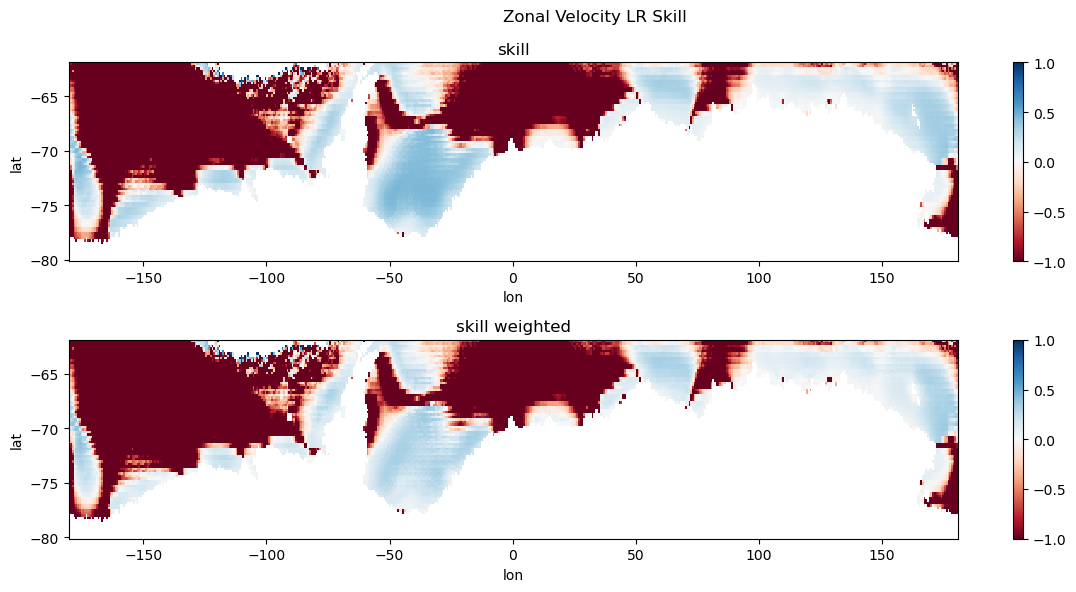

In [20]:
sk = do_skill(np.real(fit), np.real(true))
sk_weighted = do_skill_weighted(np.real(fit), np.real(true), rt)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, sk, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, sk_weighted, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('skill weighted')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Zonal Velocity LR Skill')

fig.tight_layout()

/tmp/ipykernel_2236790/3333116023.py:8: RuntimeWarning: Mean of empty slice
  plt0 = axs[0].pcolormesh(lon, lat, np.nanmean(u_fit, axis = 0), cmap = cmap, vmin = -1, vmax = 1)
/tmp/ipykernel_2236790/3333116023.py:14: RuntimeWarning: Mean of empty slice
  plt1 = axs[1].pcolormesh(lon, lat, np.nanmean(u_true, axis = 0), cmap = cmap, vmin = -1, vmax = 1)


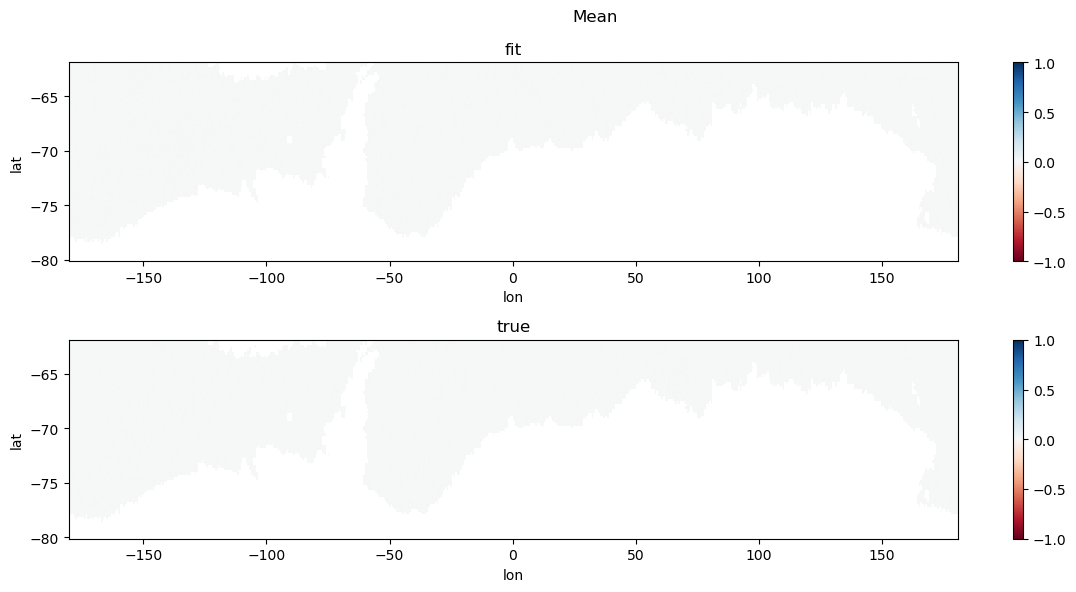

In [21]:
u_fit = np.real(fit)
u_true = np.real(true)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, np.nanmean(u_fit, axis = 0), cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, np.nanmean(u_true, axis = 0), cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

fig.suptitle('Mean')

fig.tight_layout()

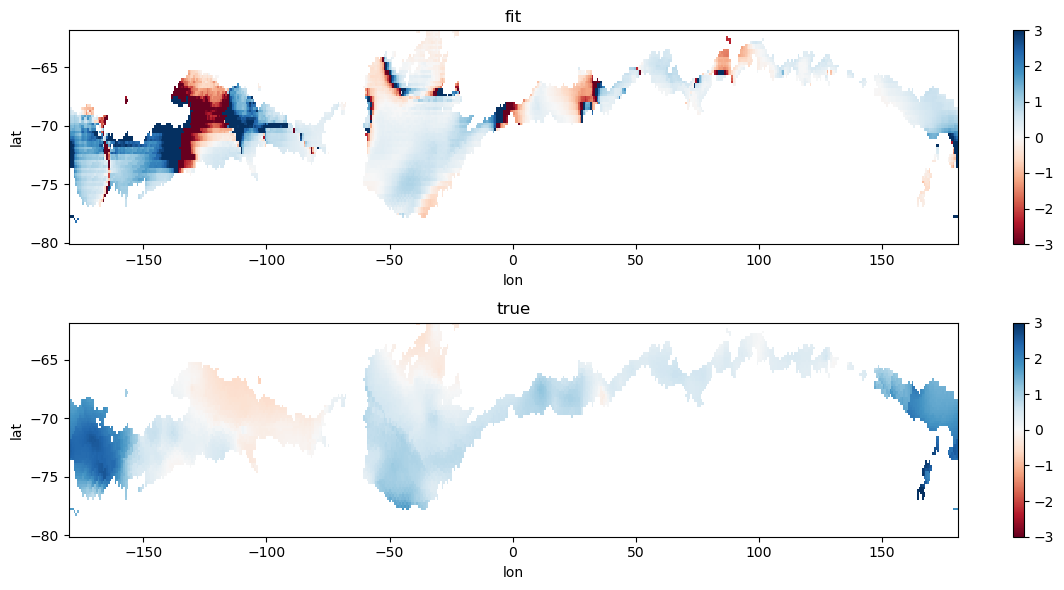

In [22]:
u_fit = np.real(fit)
u_true = np.real(true)

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

In [23]:
def lr_gridwise_nomean(uit, vit, uwt, vwt, icy):
    """Same as above gridwise LR, but excluding mean as regression parameter"""
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 2)), dtype = complex) # first column constant (1)

                    G[:,0] = wt_c # Complex wind, today
                    G[:,1] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Find model paremeters
                    m = (np.linalg.inv(G.T @ G)) @ G.T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

In [24]:
m_nm, fit_nm, true_nm = lr_gridwise_nomean(uit, vit, uwt, vwt, icy)

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


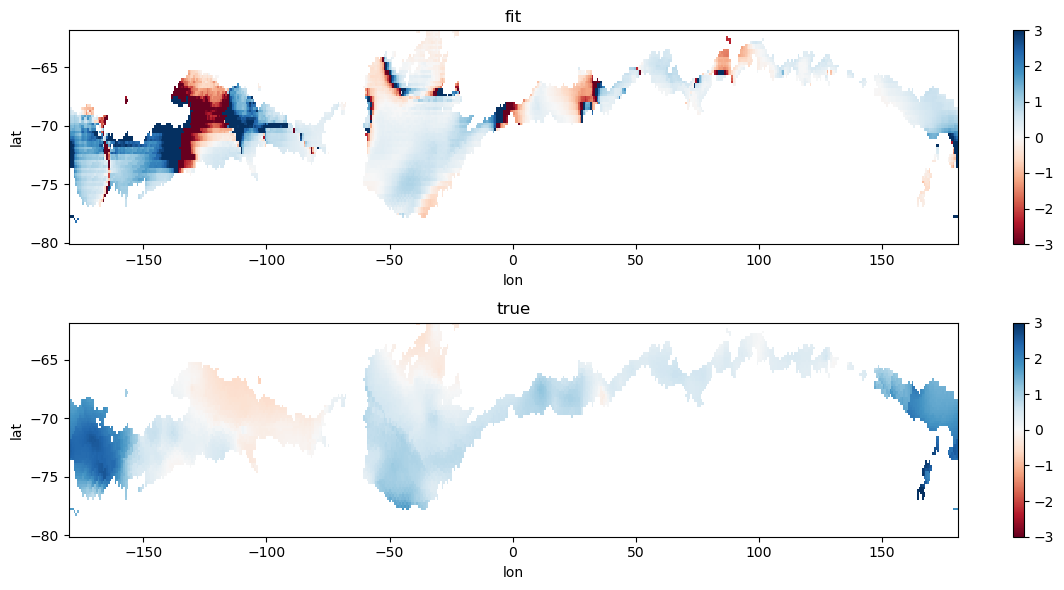

In [25]:
u_fit = np.real(fit_nm)
u_true = np.real(true_nm)

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

In [26]:
def lr_gridwise_nomean_imc0(uit, vit, uwt, vwt, icy):
    """Same as above gridwise LR, but excluding mean as regression parameter AND imag concentration is 0"""
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + 0*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 2)), dtype = complex) # first column constant (1)

                    G[:,0] = wt_c # Complex wind, today
                    G[:,1] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Find model paremeters
                    m = (np.linalg.inv(G.T @ G)) @ G.T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


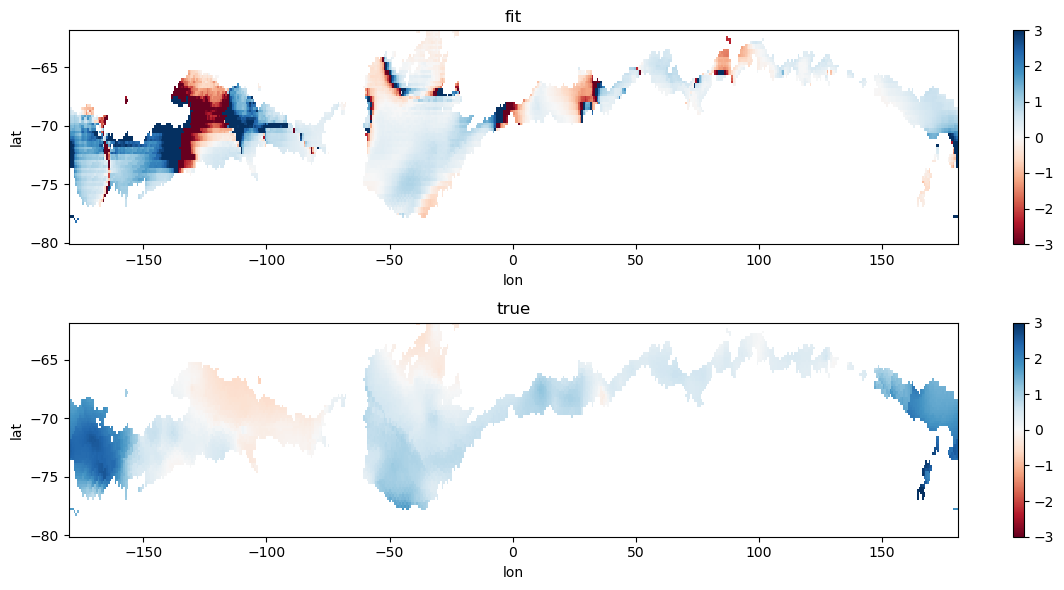

In [27]:
m_nm_imc0, fit_nm_imc0, true_nm_imc0 = lr_gridwise_nomean_imc0(uit, vit, uwt, vwt, icy)

u_fit = np.real(fit_nm_imc0)
u_true = np.real(true_nm_imc0)

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

In [28]:
def lr_gridwise_conjT(uit, vit, uwt, vwt, icy):
    """ 
    *** CAUTION *** THIS is WRONG - NO conjugate transpose on data vector 'd' (y_true)
    * The only reason we transpose in code is to make it a vector from an array (see derivation)
    Same as above gridwise LR, but with complex conjugate transpose
    aka 'Hermitian transpose'
    
    * NOTE - no .H operation on numpy ndarray
    
    """
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.conj().T

                    # Find model paremeters
                    m = (LA.inv(G.conj().T @ G)) @ G.conj().T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


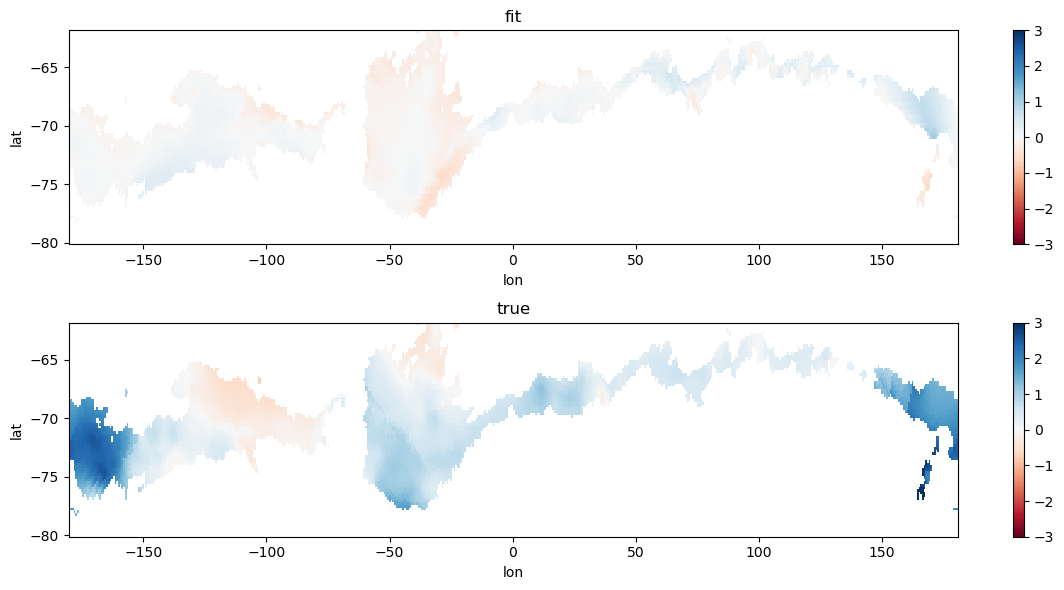

In [29]:
m_conjT, fit_conjT, true_conjT = lr_gridwise_conjT(uit, vit, uwt, vwt, icy)

u_fit = np.real(fit_conjT)
u_true = np.real(true_conjT)

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

# Unweighted LR v1

### Gridwise normalization in loop
> ### 1. Remove Mean (over time dimension)
> ### 2. Divide by grid respective STD (over time dimension)

In [30]:
def lr_gridwise_dnoconjT(uit, vit, uwt, vwt, icy):
    """ 
    Same as above gridwise LR, but with complex conjugate transpose
    EXCEPT on the data vector of true values
    *The only reason we transpose d at all here is because we want it to be a column vector (from array)
    aka 'Hermitian transpose'
    * NOTE - no .H operation on numpy ndarray
    
    """
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Find model paremeters
                    m = (LA.inv(G.conj().T @ G)) @ G.conj().T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


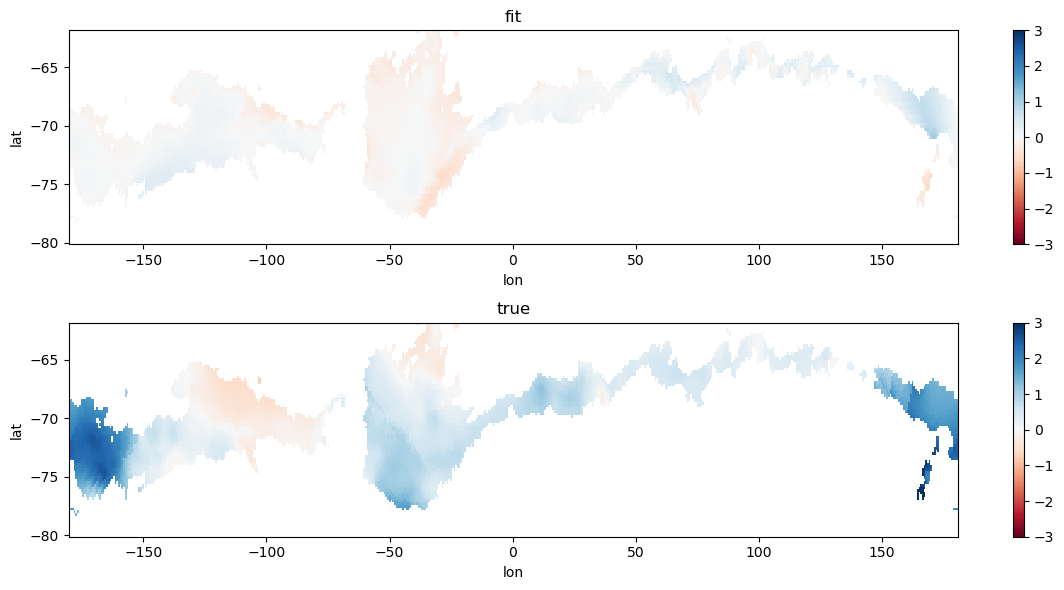

In [31]:
m_dnoconjT, fit_dnoconjT, true_dnoconjT = lr_gridwise_dnoconjT(uit, vit, uwt, vwt, icy)

u_fit = np.real(fit_conjT)
u_true = np.real(true_conjT)

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

# Unweighted LR v1 Skill & Weighted Skill

/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


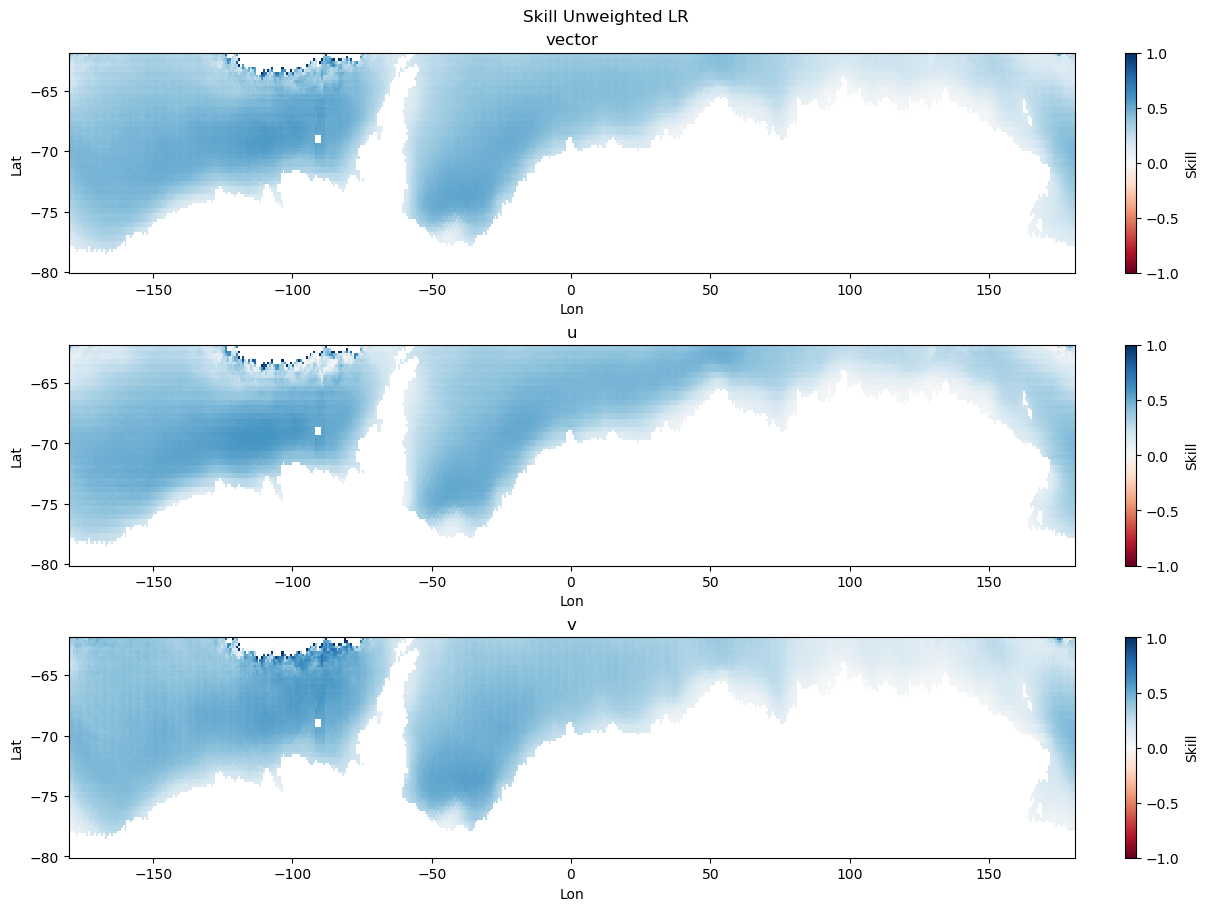

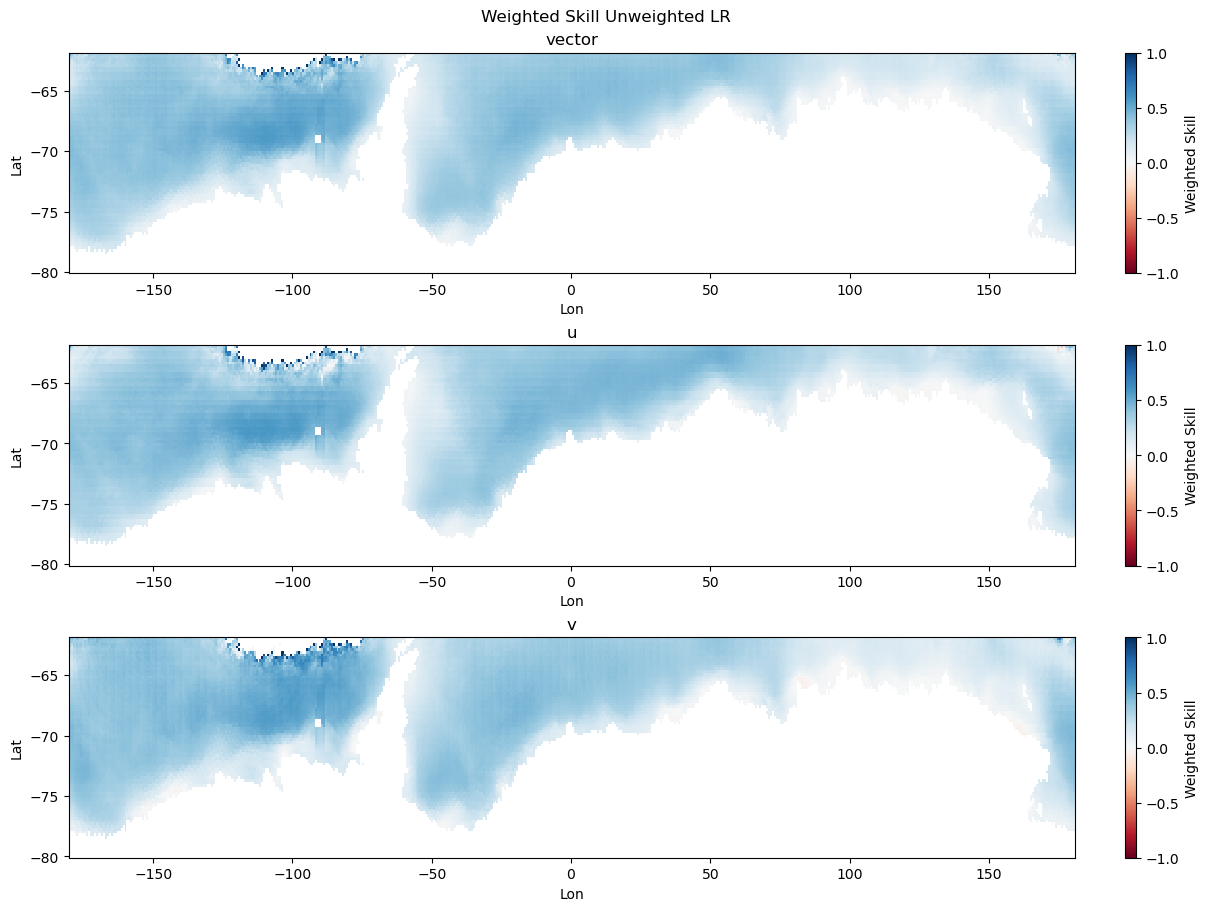

/tmp/ipykernel_2236790/1007861887.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_vector = np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/1007861887.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_u = np.nanvar(np.real(true), axis = 0)


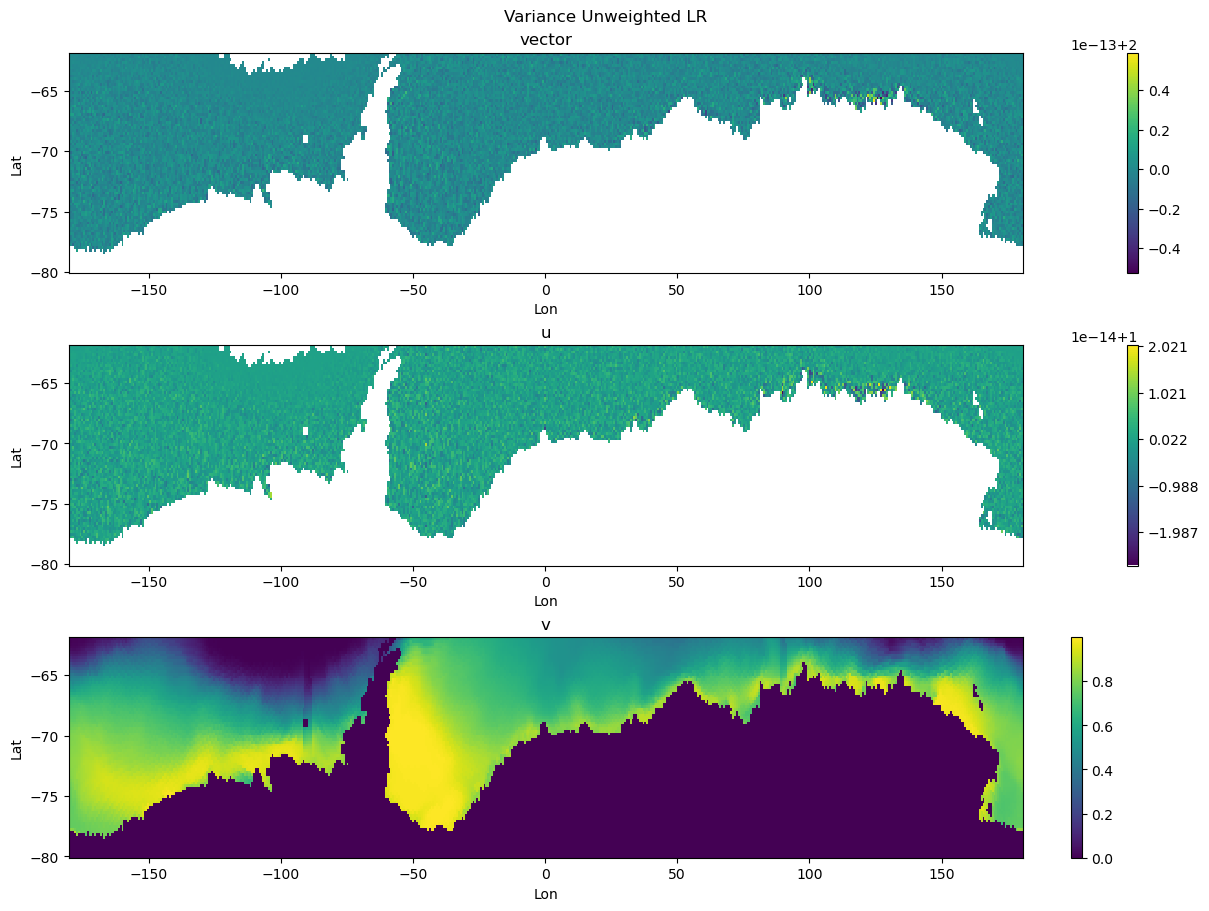

In [65]:
skill_z, skill_u, skill_v, w_skill_z, w_skill_u, w_skill_v = return_plot_skill(fit_dnoconjT, true_dnoconjT, rt, 'Unweighted LR')

# Weighted LR v1

### Gridwise normalization in loop
> ### 1. Remove Mean (over time dimension)
> ### 2. Divide by grid respective STD (over time dimension)

In [33]:
def lr_weighted_gridwise(uit, vit, uwt, vwt, icy, rt, epsilon):
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)
    rt_n_all = np.full((nt, ny, nx), np.nan)
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]
                    rt_f = rt[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)
                    rt_n = normalize(rt_f)
                    
                    # Store gridwise normalized uncertainty in array
                    rt_n_all[true_mask, iy ,ix] = rt_n

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T
                    
                    rr = 2 * ((rt_n ** 2) + epsilon)
                    rr = 1 / rr

                    # Create diagonal matrix of uncertainty
                    R = np.diag(rr)

                    # Weighted model parameters
                    m = (LA.inv(G.conj().T @ R @ G)) @ G.conj().T @ R @ d # (adapted from eqn 39, SIOC221B Lec 10)

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all, rt_n_all

In [34]:
# Weighted LR with 0.001 added to uncertainty r to avoid zero division
wlr_m, wlr_fit, wlr_true, rt_n_all = lr_weighted_gridwise(uit, vit, uwt, vwt, icy, rt, 0.001)

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


iy 73 complete
Error at iy=74, ix=108: Singular matrix
iy 74 complete
Error at iy=75, ix=103: Singular matrix
Error at iy=75, ix=104: Singular matrix
Error at iy=75, ix=106: Singular matrix
iy 75 complete
Error at iy=76, ix=89: Singular matrix
Error at iy=76, ix=94: Singular matrix
Error at iy=76, ix=95: Singular matrix
Error at iy=76, ix=105: Singular matrix
Error at iy=76, ix=106: Singular matrix
Error at iy=76, ix=129: Singular matrix
iy 76 complete
Error at iy=77, ix=95: Singular matrix
Error at iy=77, ix=106: Singular matrix
iy 77 complete
Error at iy=78, ix=109: Singular matrix
Error at iy=78, ix=126: Singular matrix
Error at iy=78, ix=149: Singular matrix
iy 78 complete
iy 79 complete
Error at iy=80, ix=134: Singular matrix
iy 80 complete


# Weighted LR v1 Skill & Weighted Skill

/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


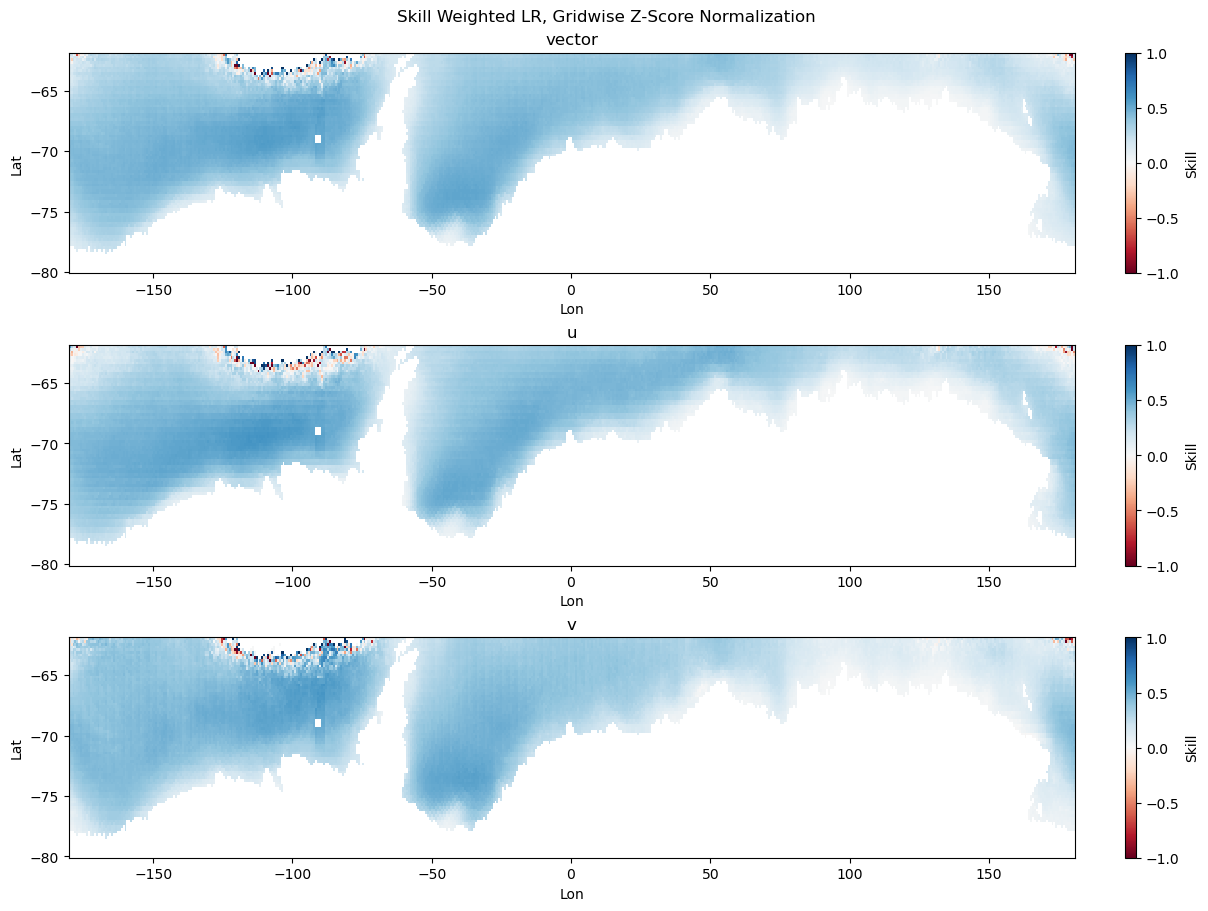

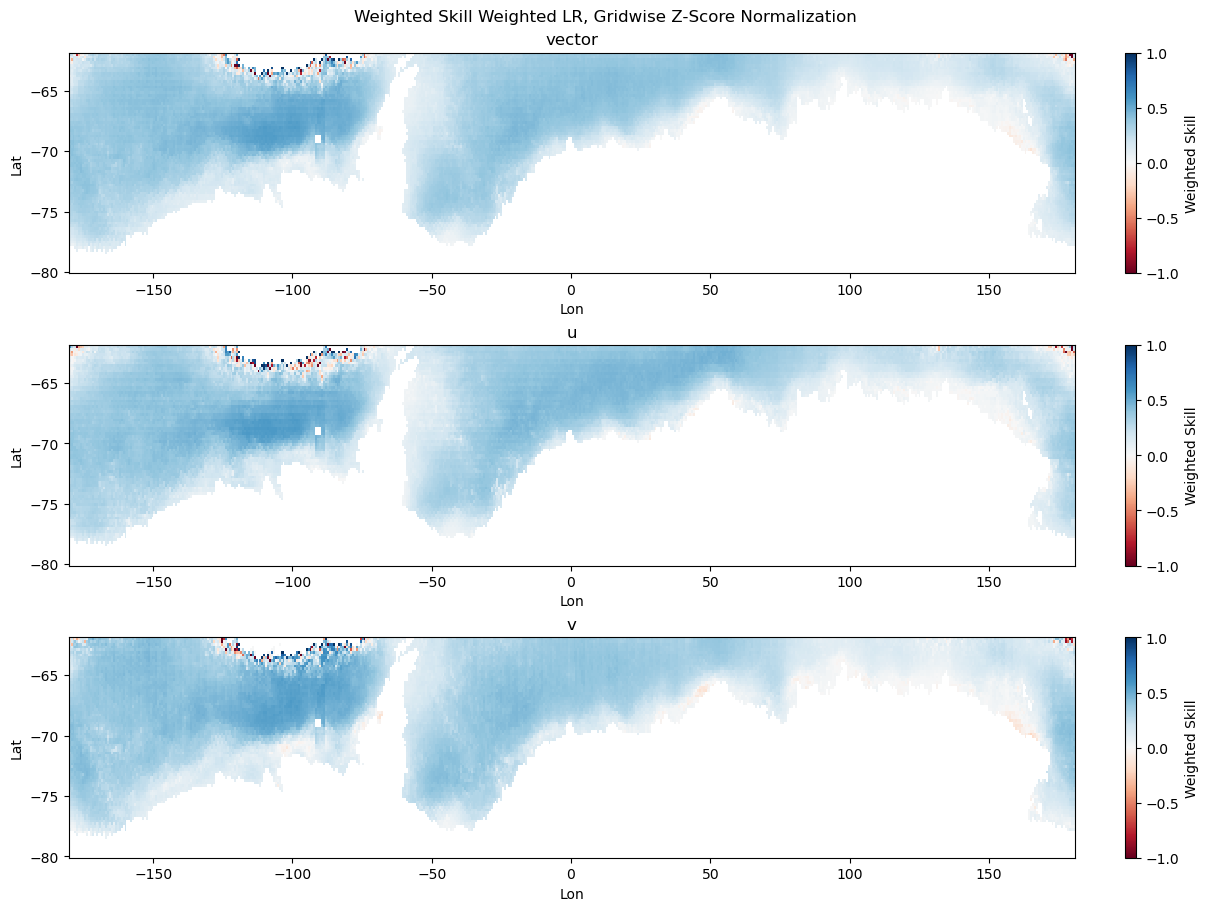

/tmp/ipykernel_2236790/1007861887.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_vector = np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/1007861887.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_u = np.nanvar(np.real(true), axis = 0)


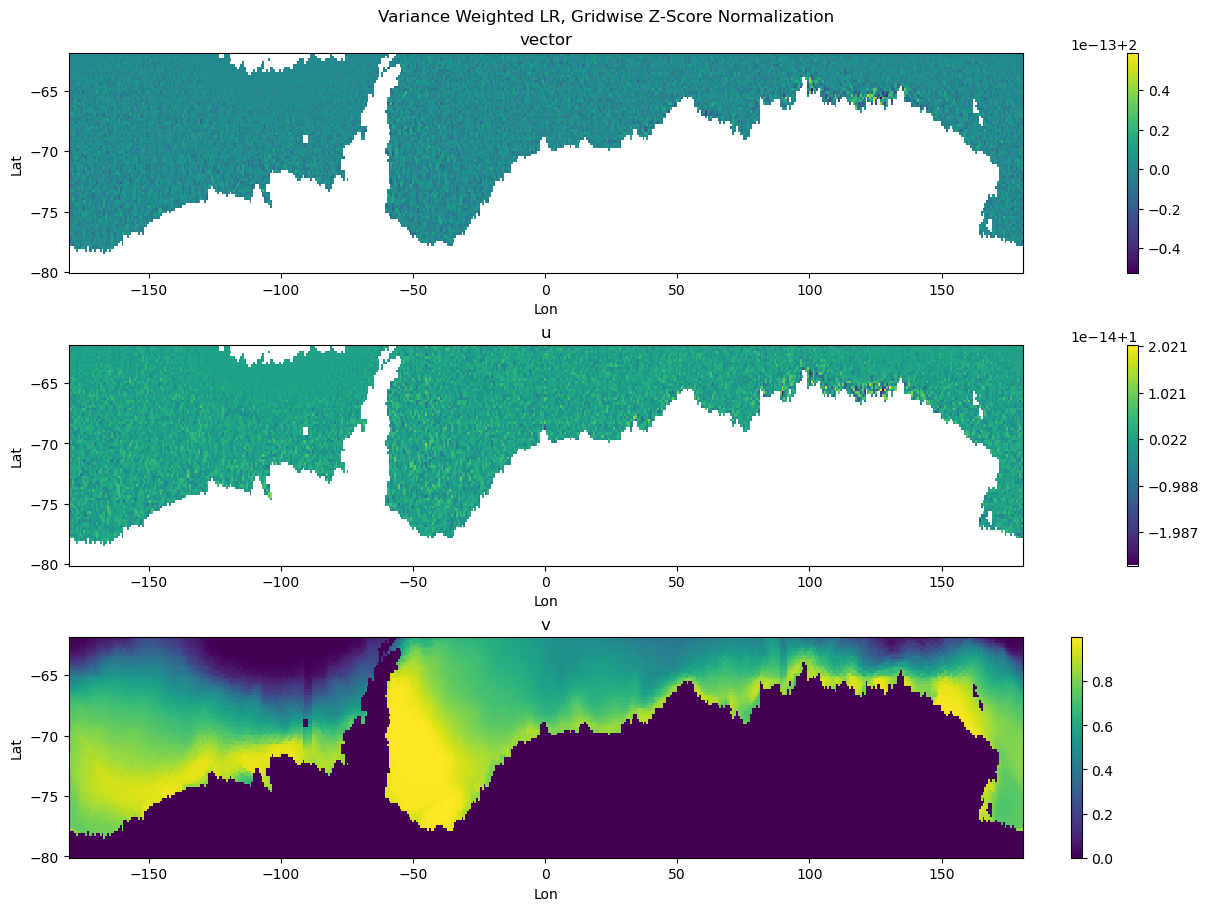

In [66]:
wlr_skill_z, wlr_skill_u, wlr_skill_v, wlr_w_skill_z, wlr_w_skill_u, wlr_w_skill_v = return_plot_skill(wlr_fit, wlr_true, rt, 'Weighted LR, Gridwise Z-Score Normalization')

/tmp/ipykernel_2236790/345893780.py:3: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis = 0)
/tmp/ipykernel_2236790/2529940655.py:4: RuntimeWarning: Mean of empty slice
  mean_norm = np.nanmean(normalize(rt_n_all), axis = 0)


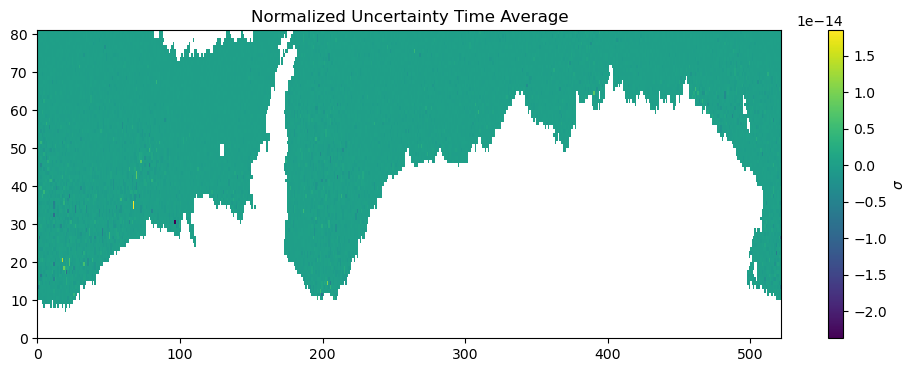

In [36]:
# Simlar to above, plot up the uncertainty
# BUT uncertainty is normalized in gridwise loop, here

mean_norm = np.nanmean(normalize(rt_n_all), axis = 0)
vmin = np.nanmin(mean_norm)
vmax = np.nanmax(mean_norm)

plt.figure(figsize = (12, 4))
plt.pcolormesh(mean_norm, vmin = vmin, vmax = vmax)
cb = plt.colorbar()
cb.set_label(r'$ \sigma $')
plt.title(r'Normalized Uncertainty Time Average')
plt.show()

# # Flag uncerainty values less than 0.01 cm/s, greater than 1000 cm/s as 9999
# rt_n_flag = (np.where((rt <= 0.01 | rt >= 1000), 9999, rt))

### STILL CLOSE TO ZERO ###

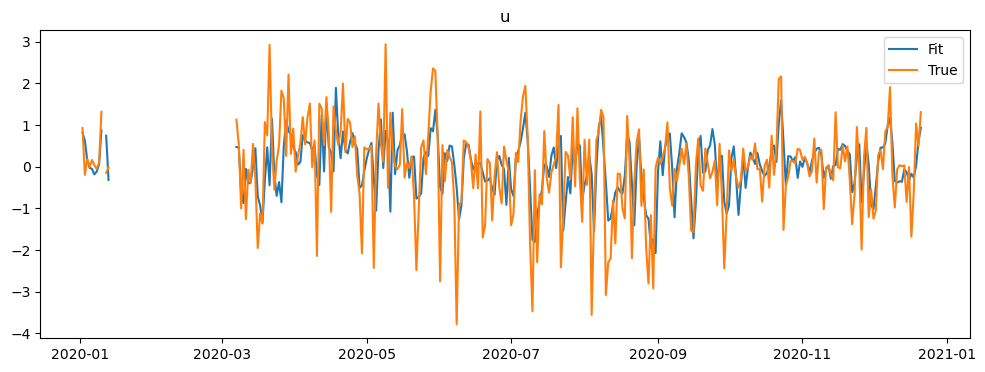

In [37]:
# Verify fit

# Ross sea - wild one from last week, should be similar to Weddell

yy = 15
xx = 20

plt.figure(figsize = (12,4))

plt.plot(tt[-365:], np.real(wlr_fit[-365:, yy, xx]), label = 'Fit')
plt.plot(tt[-365:], np.real(wlr_true[-365:, yy, xx]), label = 'True')
plt.legend()
plt.title('u')
plt.show()

# NO MORE OVERFITTING - THE INVERSION WAS SUCCESSFUL WITH THE COMPLEX CONJUGATE TRANSPOSE

### Explore Variance in True Values

/tmp/ipykernel_2236790/3162628966.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varvals[i,:,:] = np.nanvar(data[i], axis = 0)


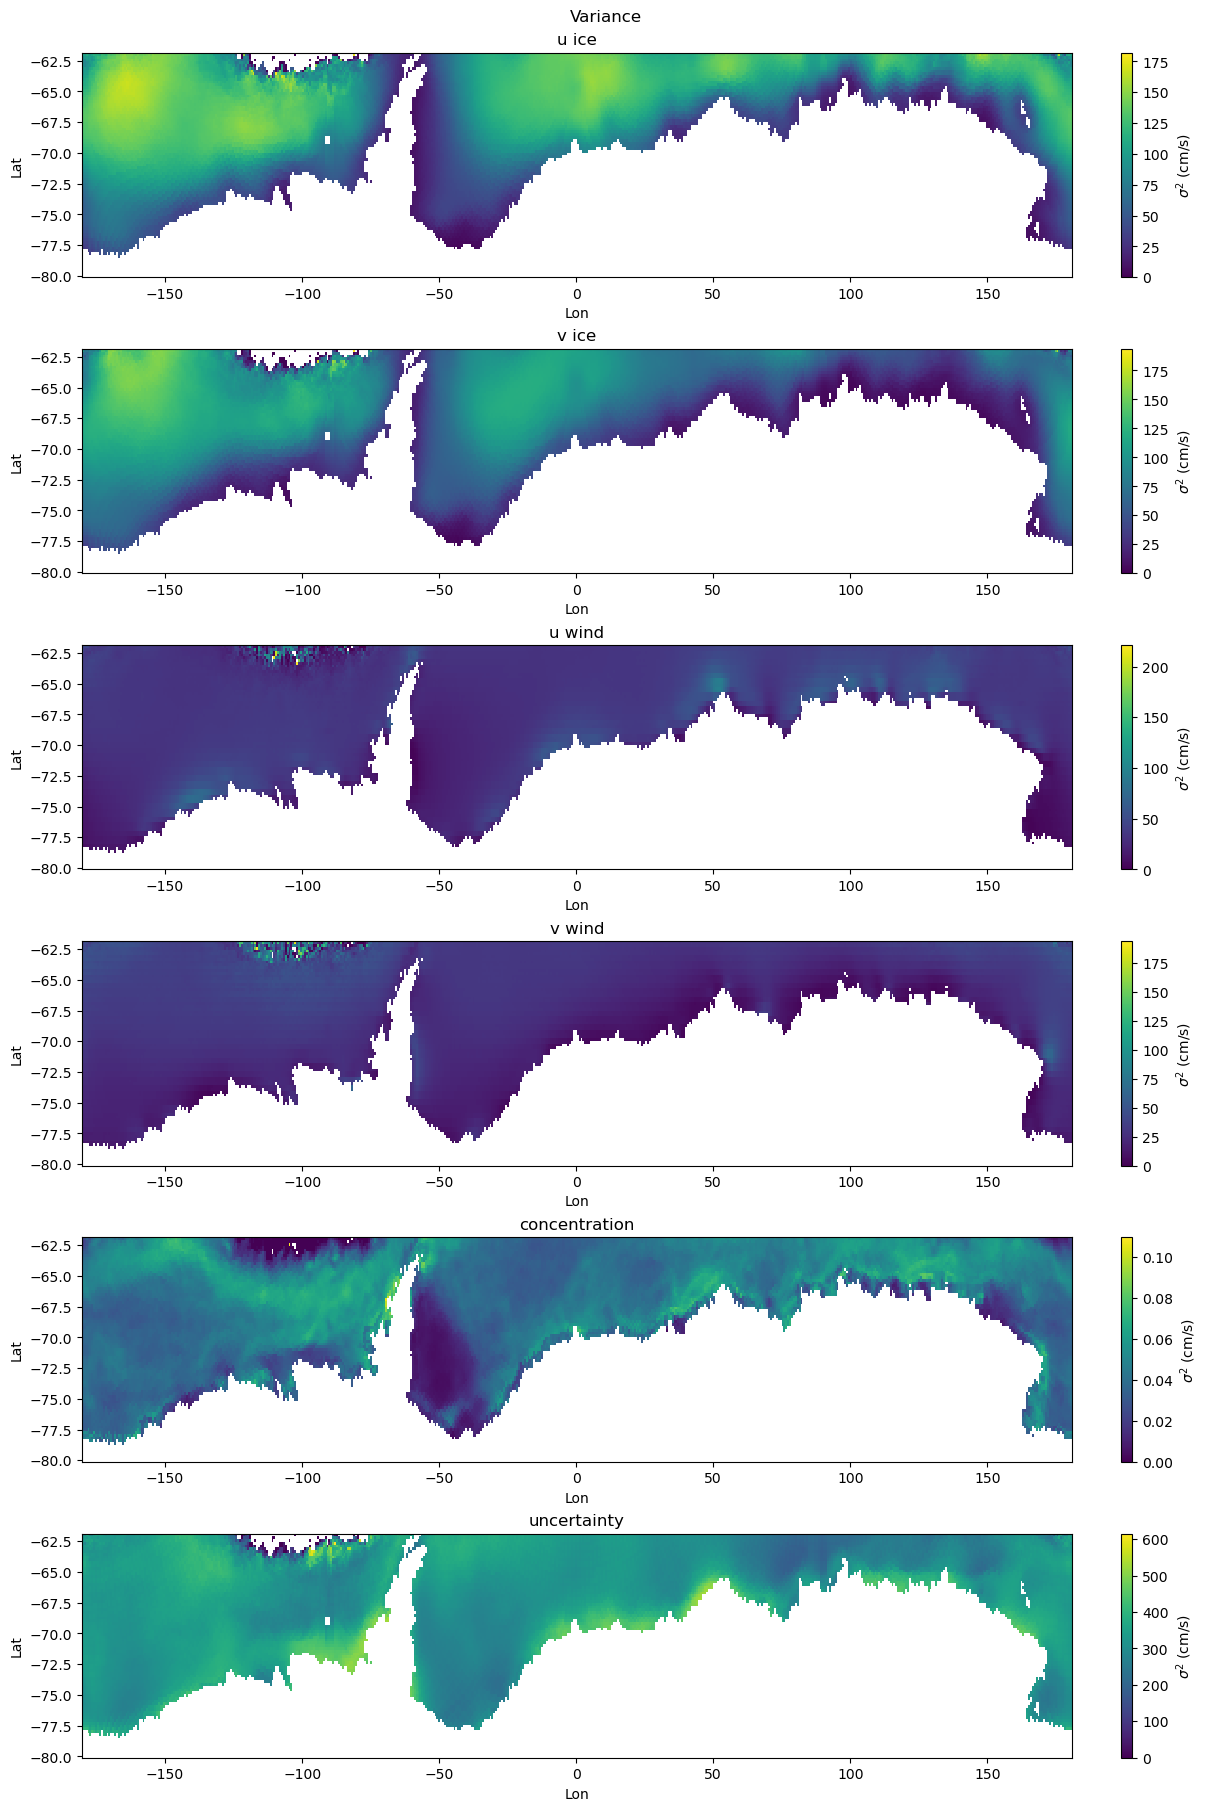

In [40]:
data = [uit, vit, uwt, vwt, icy, rt] 

nt, ny, nx = np.shape(uit)
nd = len(data)

# Before normalizing
varvals = np.zeros((nd, ny, nx))

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, 3*nd), constrained_layout=True)
titles = ['u ice', 'v ice', 'u wind', 'v wind', 'concentration', 'uncertainty']


for i in range(nd):
    
    varvals[i,:,:] = np.nanvar(data[i], axis = 0)
    
    pcm = axs[i].pcolormesh(lon, lat, varvals[i,:,:])
    fig.colorbar(pcm, ax=axs[i], label=r'$ \sigma^2 $ (cm/s)')
    axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
    
fig.suptitle('Variance')

plt.show()

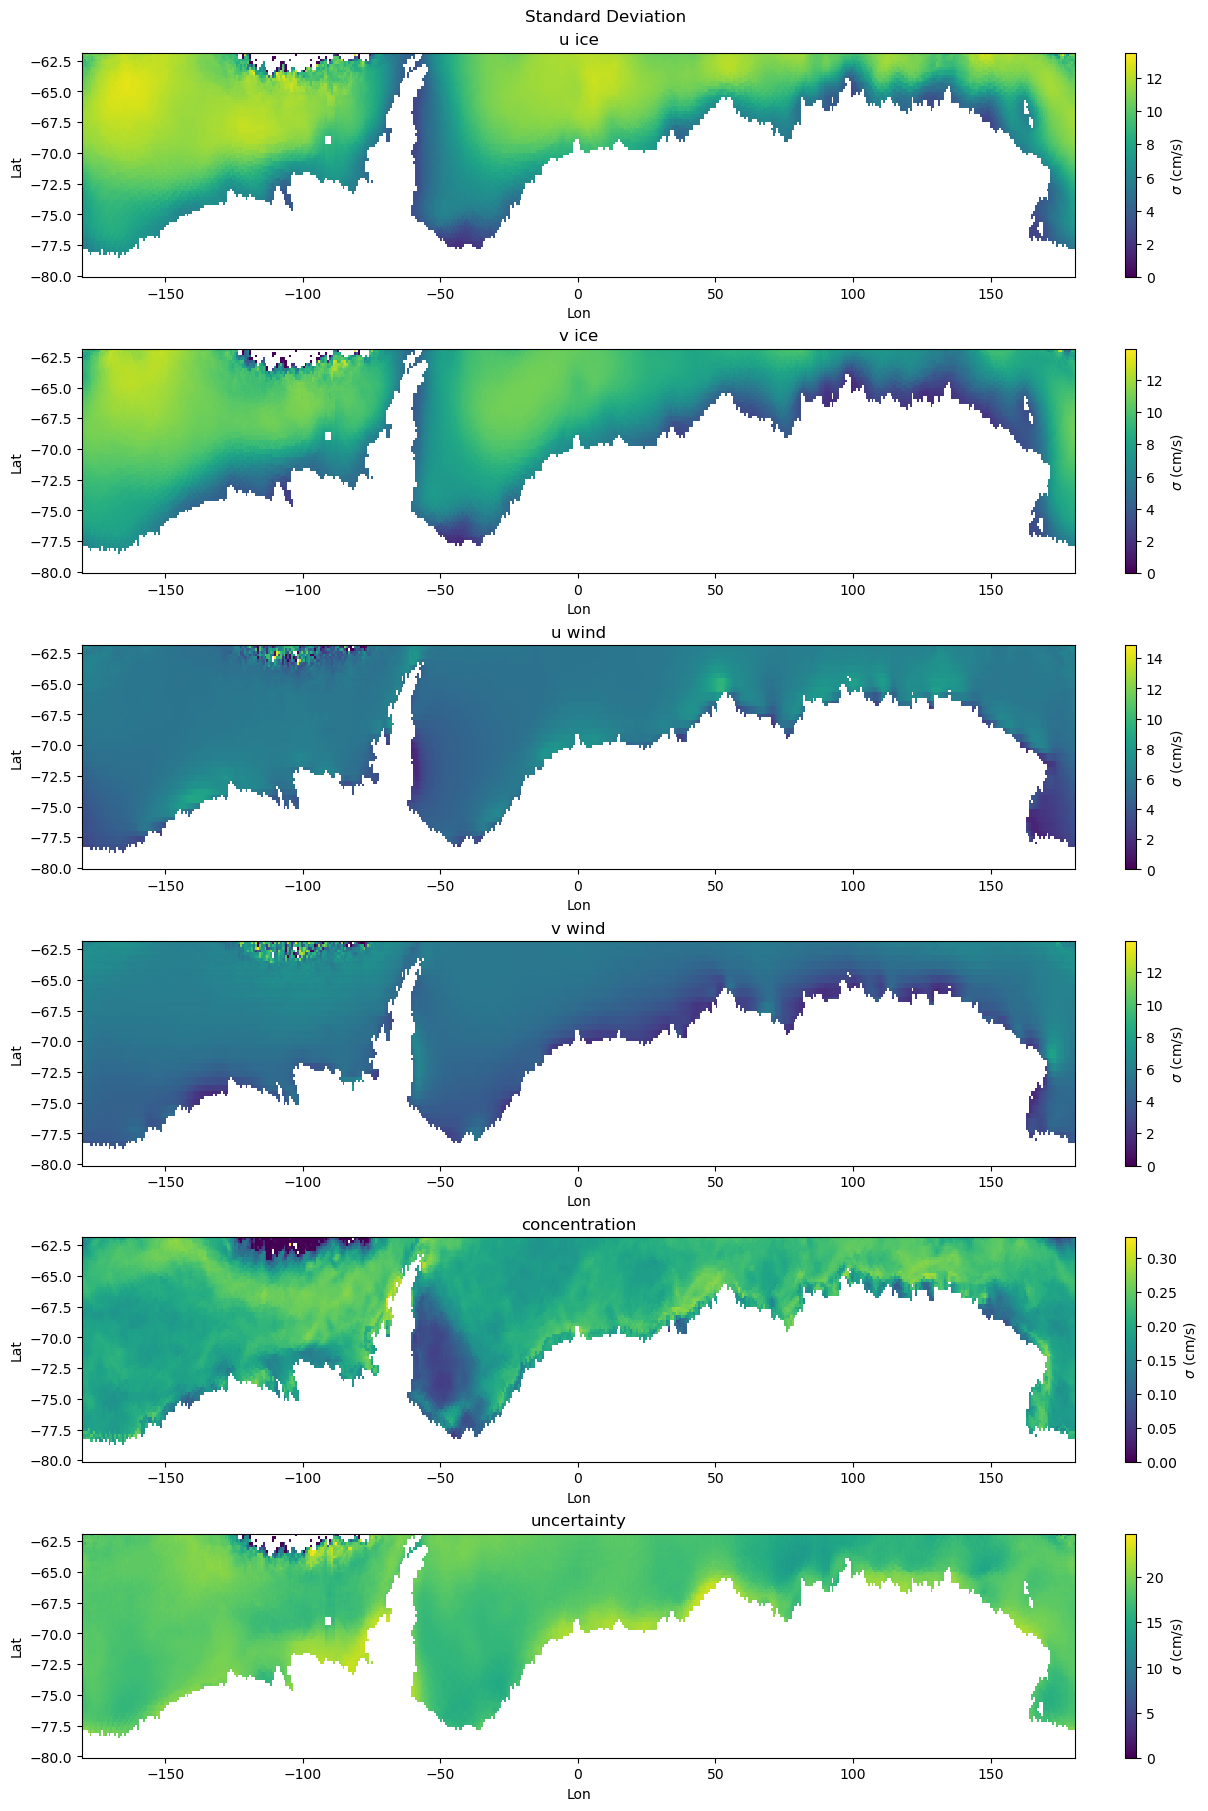

In [41]:
# Std
stds = np.zeros((nd, ny, nx))

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, 3*nd), constrained_layout=True)
titles = ['u ice', 'v ice', 'u wind', 'v wind', 'concentration', 'uncertainty']


for i in range(nd):
    
    stds[i,:,:] = np.nanstd(data[i], axis = 0)
    
    pcm = axs[i].pcolormesh(lon, lat, stds[i,:,:])
    fig.colorbar(pcm, ax=axs[i], label=r'$ \sigma $ (cm/s)')
    axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
    
fig.suptitle('Standard Deviation')

plt.show()

/tmp/ipykernel_2236790/345893780.py:3: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis = 0)
/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


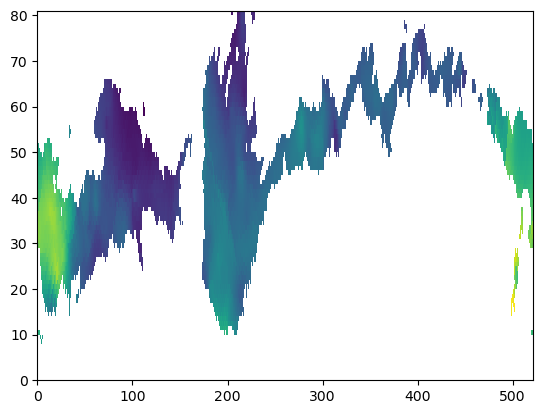

/tmp/ipykernel_2236790/4267900959.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_norm_uit = np.nanvar(norm_uit, axis = 0)


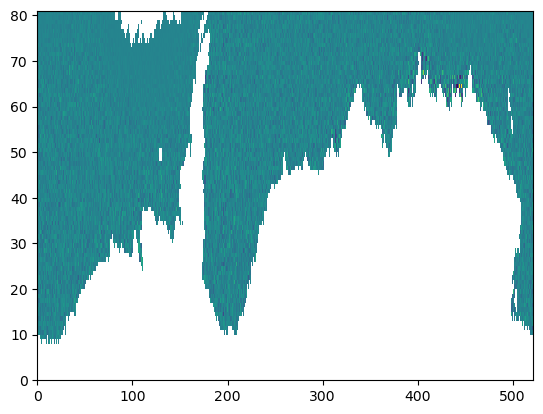

In [42]:
norm_uit = normalize(uit)

plt.pcolormesh(norm_uit[-2,:,:])
plt.show()

var_norm_uit = np.nanvar(norm_uit, axis = 0)

plt.pcolormesh(var_norm_uit)
plt.show()

/tmp/ipykernel_2236790/345893780.py:3: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis = 0)
/tmp/ipykernel_2236790/345893780.py:5: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std
/tmp/ipykernel_2236790/3839765602.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varvals_norm[i,:,:] = np.nanvar(normval, axis = 0)


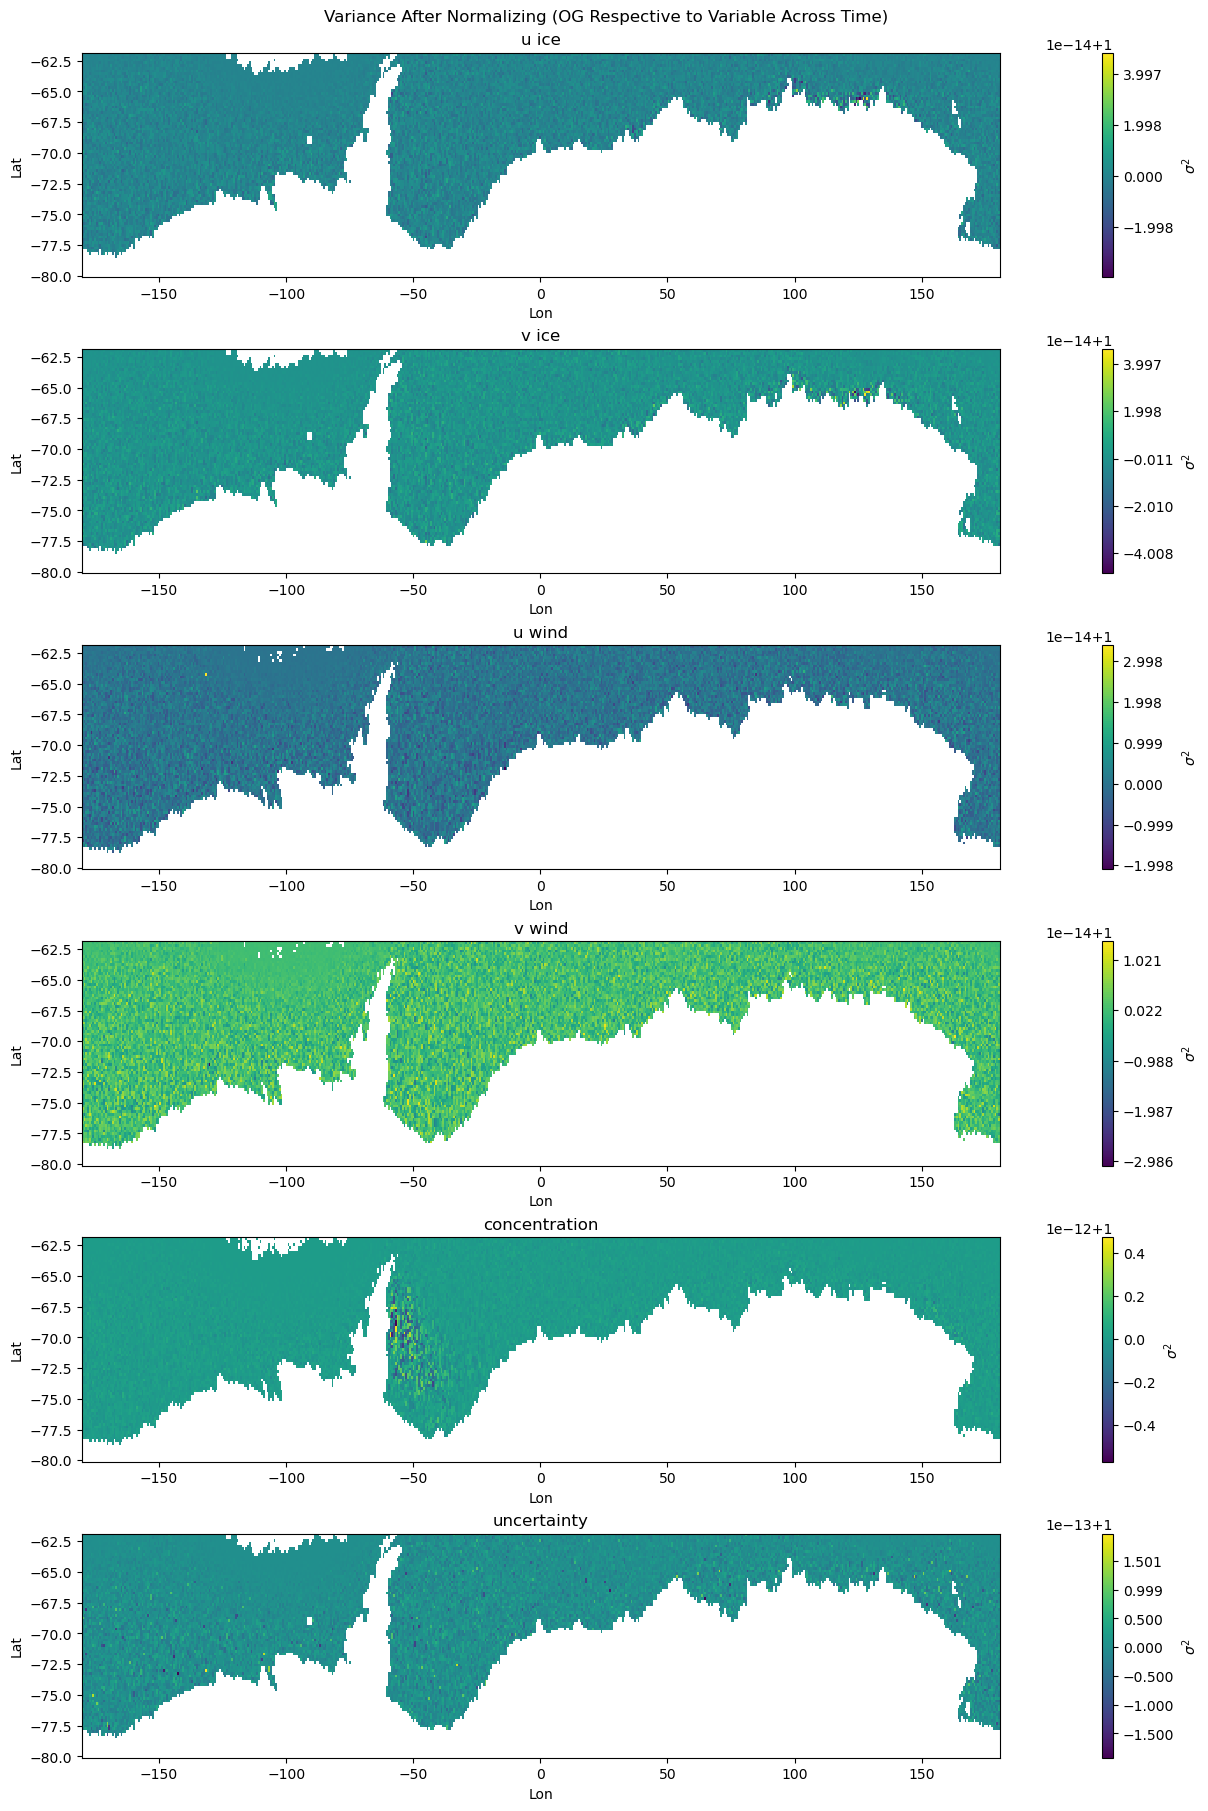

In [43]:
# After Normalizing

# Before normalizing
varvals_norm = np.zeros((nd, ny, nx))

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, 3*nd), constrained_layout=True)
titles = ['u ice', 'v ice', 'u wind', 'v wind', 'concentration', 'uncertainty']


for i in range(nd):
    
    normval = normalize(data[i])
    varvals_norm[i,:,:] = np.nanvar(normval, axis = 0)
    
    pcm = axs[i].pcolormesh(lon, lat, varvals_norm[i,:,:])
    fig.colorbar(pcm, ax=axs[i], label=r'$ \sigma^2 $')
    axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
    
fig.suptitle('Variance After Normalizing (OG Respective to Variable Across Time)')

plt.show()

# Weighted LR v1

### Global Normalization with global STD last 2 years (2018 - 2020)
> ### 1. Remove Mean GRIDWISE (over time dinemsion)
> ### 2. Divide by global STD 2 years (2018 - 2020)

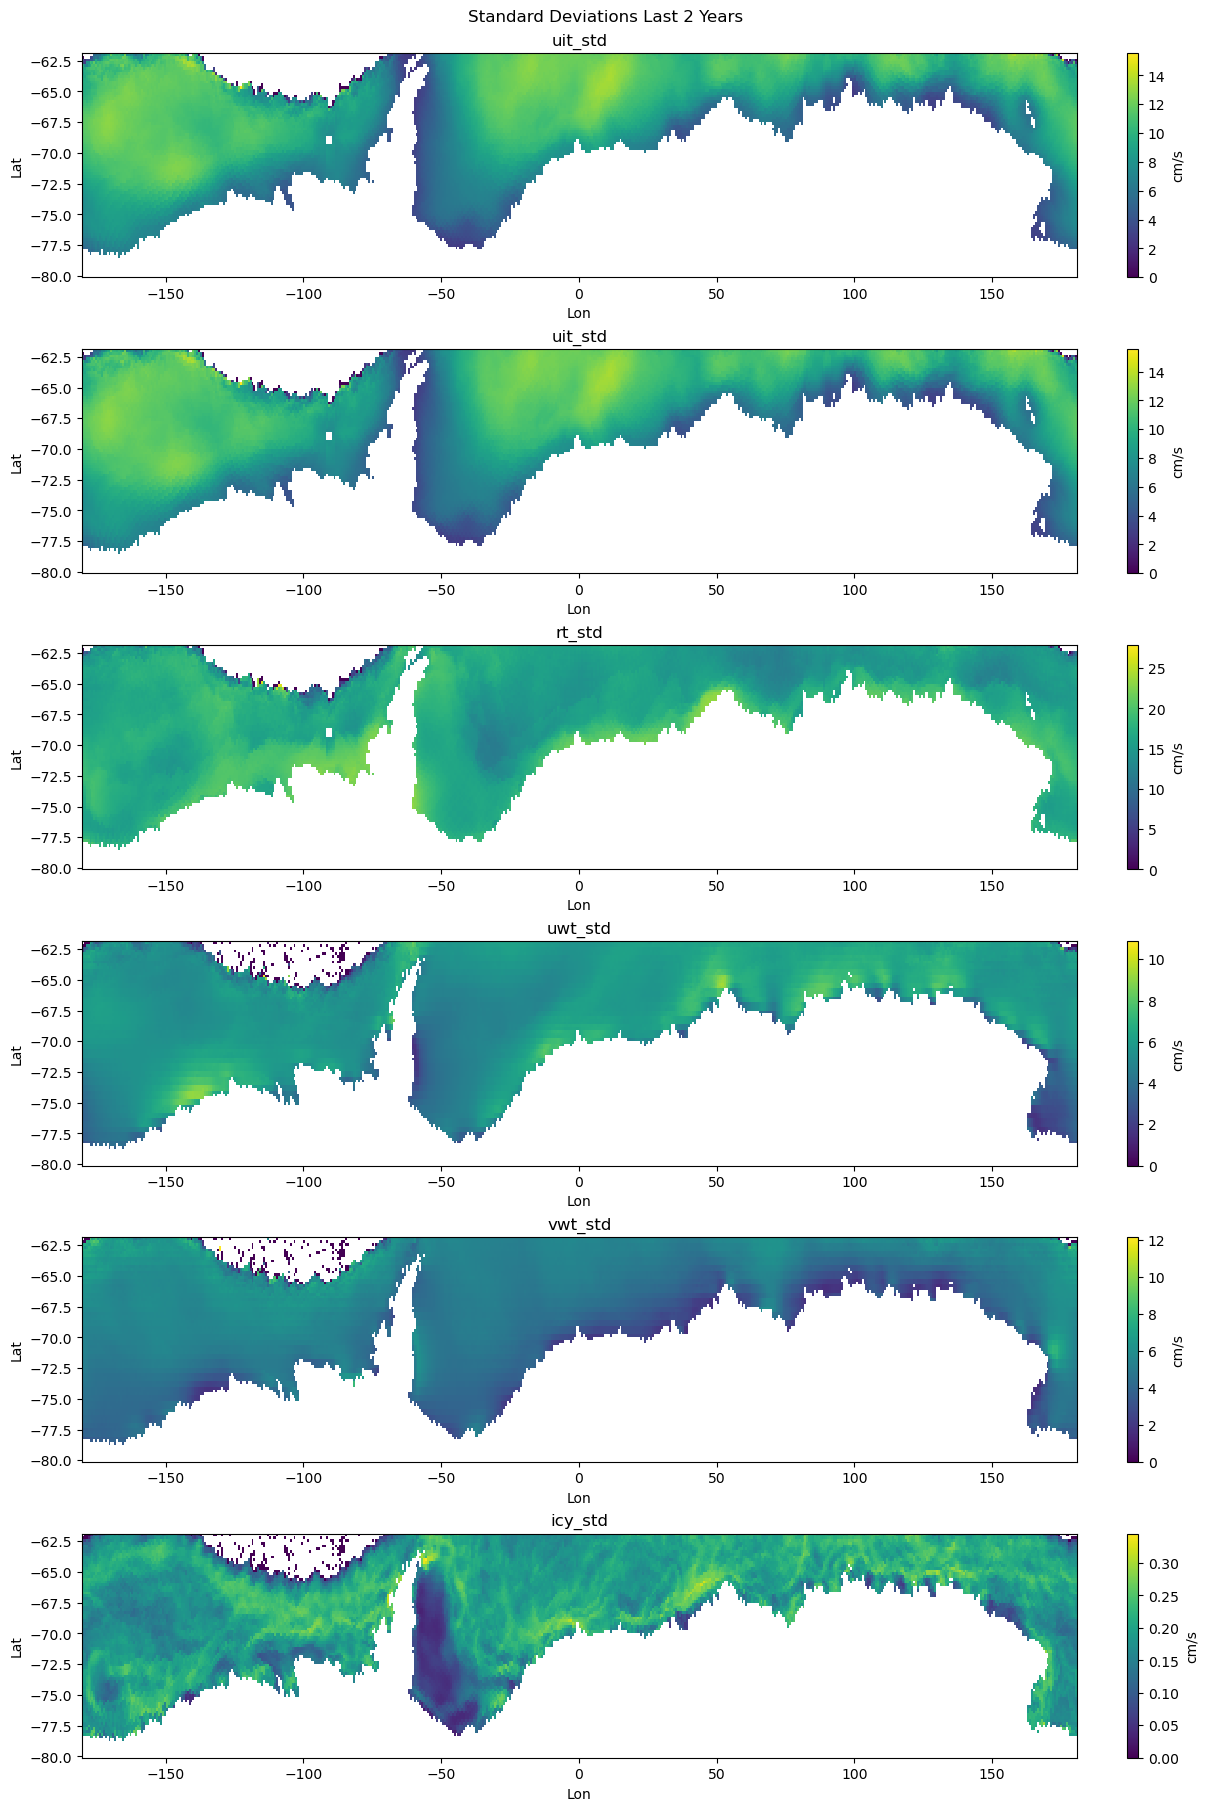

In [44]:
# Gridwise STDs Last {nyrs} Years

nyrs = 2
ndys = 365 * nyrs # Two years time points

uit_std = np.nanstd(uit[-ndys:,:,:], axis = 0) # 'today' zonal ice velocity Standard dev
vit_std = np.nanstd(vit[-ndys:,:,:], axis = 0) # 'today' meridional ice velocity Standard dev 
rt_std = np.nanstd(rt[-ndys:,:,:], axis = 0) # 'today' ice velocity uncertainty Standard dev 
uwt_std = np.nanstd(uwt[-ndys:,:,:], axis = 0) # 'today' zonal wind Standard dev 
vwt_std = np.nanstd(vwt[-ndys:,:,:], axis = 0) # 'today' meridional wind Standard dev 
icy_std = np.nanstd(icy[-ndys:,:,:], axis = 0) # 'yesterday' ice concntration Standard dev 

stds = [uit_std, uit_std, rt_std, uwt_std, vwt_std, icy_std]
titles = ['uit_std', 'uit_std', 'rt_std', 'uwt_std', 'vwt_std', 'icy_std']
    
fig, axs = plt.subplots(nrows=len(stds), ncols=1, figsize=(12, len(stds) * 3), constrained_layout=True)
    
for i, std in enumerate(stds):
    pcm = axs[i].pcolormesh(lon, lat, std)
    fig.colorbar(pcm, ax=axs[i], label=r'cm/s')
    axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')

fig.suptitle(f'Standard Deviations Last {nyrs} Years')
plt.show()

# Normalize to 0 mean and 1 STD - Based on Global Statistics

In [47]:
# Global STDs

# 1. Remove global mean from the data
uit_nm = uit - np.nanmean(uit) # 'today' zonal ice velocity, global removed
vit_nm = vit - np.nanmean(vit) # 'today' meridional ice velocity, global mean removed
rt_nm = rt - np.nanmean(rt) # 'today' ice velocity uncertainty, global mean removed
uwt_nm = uwt - np.nanmean(uwt) # 'today' zonal wind, global mean removed
vwt_nm = vwt - np.nanmean(vwt) # 'today' meridional wind, global mean removed
icy_nm = icy - np.nanmean(icy) # 'yesterday' ice concentration, global mean removed

# 2. Calculate global std for last {nyrs} years
uit_gstd = np.nanstd(uit_nm) # 'today' zonal ice velocity Standard dev
vit_gstd = np.nanstd(vit_nm) # 'today' meridional ice velocity Standard dev 
rt_gstd = np.nanstd(rt_nm) # 'today' ice velocity uncertainty Standard dev 
uwt_gstd = np.nanstd(uwt_nm) # 'today' zonal wind Standard dev 
vwt_gstd = np.nanstd(vwt_nm) # 'today' meridional wind Standard dev 
icy_gstd = np.nanstd(icy_nm) # 'yesterday' ice concntration Standard dev 


gstds = [uit_gstd, vit_gstd, rt_gstd, uwt_gstd, vwt_gstd, icy_gstd]


# 2. Calculate global std for last {nyrs} years
uit_gstd2 = np.nanstd(uit_nm[-ndys:,:,:]) # 'today' zonal ice velocity Standard dev
vit_gstd2 = np.nanstd(vit_nm[-ndys:,:,:]) # 'today' meridional ice velocity Standard dev 
rt_gstd2 = np.nanstd(rt_nm[-ndys:,:,:]) # 'today' ice velocity uncertainty Standard dev 
uwt_gstd2 = np.nanstd(uwt_nm[-ndys:,:,:]) # 'today' zonal wind Standard dev 
vwt_gstd2 = np.nanstd(vwt_nm[-ndys:,:,:]) # 'today' meridional wind Standard dev 
icy_gstd2 = np.nanstd(icy_nm[-ndys:,:,:]) # 'yesterday' ice concntration Standard dev 

gstds2 = [uit_gstd2, vit_gstd2, rt_gstd2, uwt_gstd2, vwt_gstd2, icy_gstd2]

print(gstds)
print(gstds2)

[9.513167174959152, 8.378047959826171, 19.70240773408648, 6.357262336572837, 5.17036990263555, 0.22618762282696467]
[9.475658047130219, 8.394708257727899, 18.76116522487971, 6.239774968715375, 5.072544038975089, 0.22023815987648712]


In [51]:
# 3. Normalize with z score based on global mean and global std
uit_n = uit / gstds[0] # 'today' zonal ice velocity, global z score
vit_n = vit / gstds[1] # 'today' meridional ice velocity, global z score
rt_n = rt / gstds[2] # 'today' ice velocity uncertainty, global z score
uwt_n = uwt / gstds[3] # 'today' zonal wind, global z score
vwt_n = vwt / gstds[4] # 'today' meridional wind, global z score
icy_n = icy / gstds[5] # 'yesterday' ice concentration, global z score

In [52]:
from scipy.sparse import diags

In [57]:
def lr_weighted_gridwise_gz(uit_n, vit_n, uwt_n, vwt_n, icy_n, rt_n, gstds, epsilon):
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit_n)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)
    rt_n_all = np.full((nt, ny, nx), np.nan)
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit_n[:,iy,ix]), np.isnan(vit_n[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit_n[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit_n[:,iy,ix]), np.isnan(vit_n[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit_n[true_mask, iy, ix]
                    vit_f = vit_n[true_mask, iy, ix]
                    uwt_f = uwt_n[true_mask, iy, ix]
                    vwt_f = vwt_n[true_mask, iy, ix]
                    icy_f = icy_n[true_mask, iy, ix]
                    rt_f = rt_n[true_mask, iy, ix]


                    # Convert to complex
                    it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
                    icy_c = icy_f + icy_f*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T
                    
                    rr = 2 * ((rt_f ** 2) + epsilon)
                    rr = 1 / rr

#                     # Create diagonal matrix of uncertainty
#                     R = np.diag(rr)

                    # Create diagonal matrix of uncertainty (scipy sparse for better memory)
                    R = diags(rr)

                    # Weighted model parameters
                    m = (LA.inv((G.conj().T @ R @ G))) @ G.conj().T @ R @ d # (adapted from eqn 39, SIOC221B Lec 10)

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all, rt_n_all

In [58]:
m_all_gz, fit_all_gz, true_all_gz, rt_n_all_gz = lr_weighted_gridwise_gz(uit_n, vit_n, uwt_n, vwt_n, icy_n, rt_n, gstds, 0.001)

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete
iy 64 complete
iy 65 complete
iy 66 complete
iy 67

/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/2906708764.py:3: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)


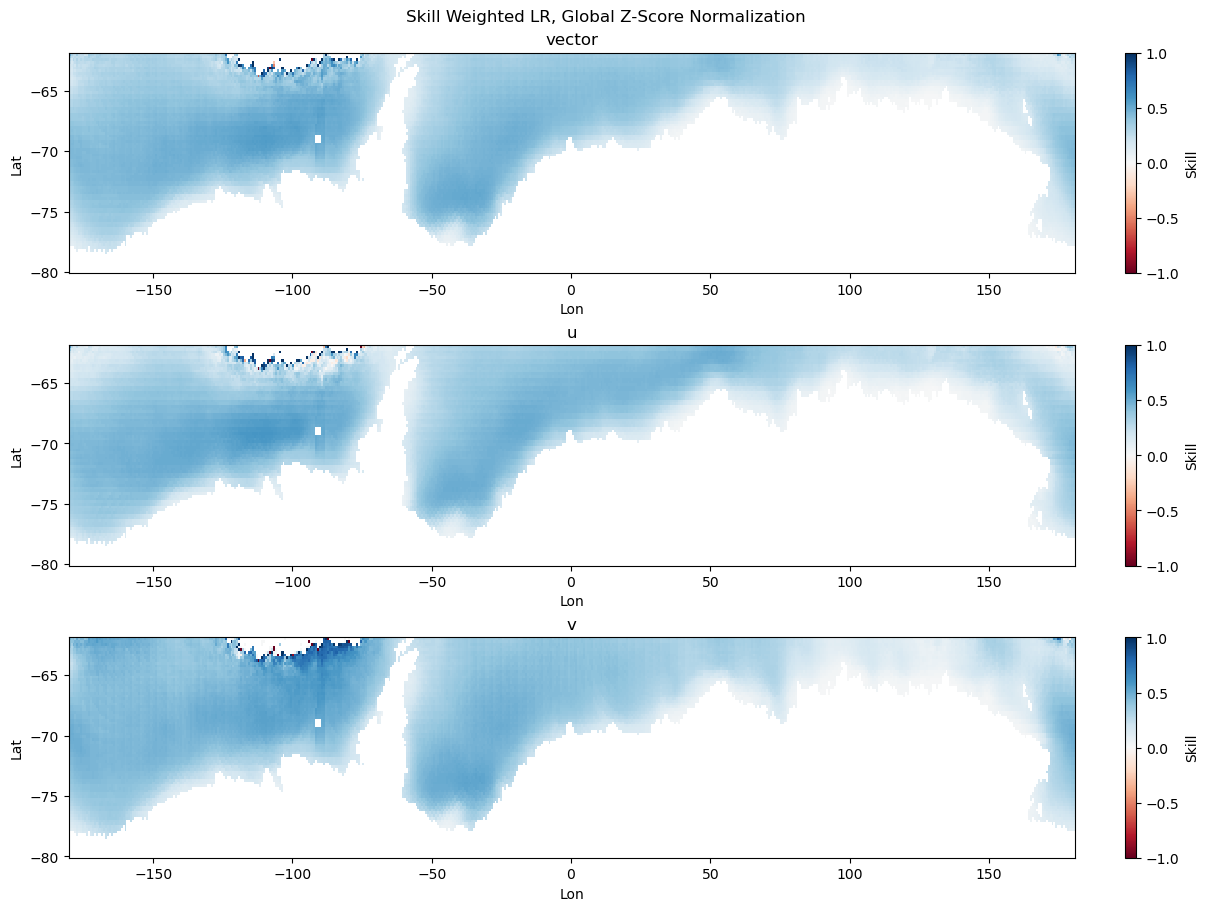

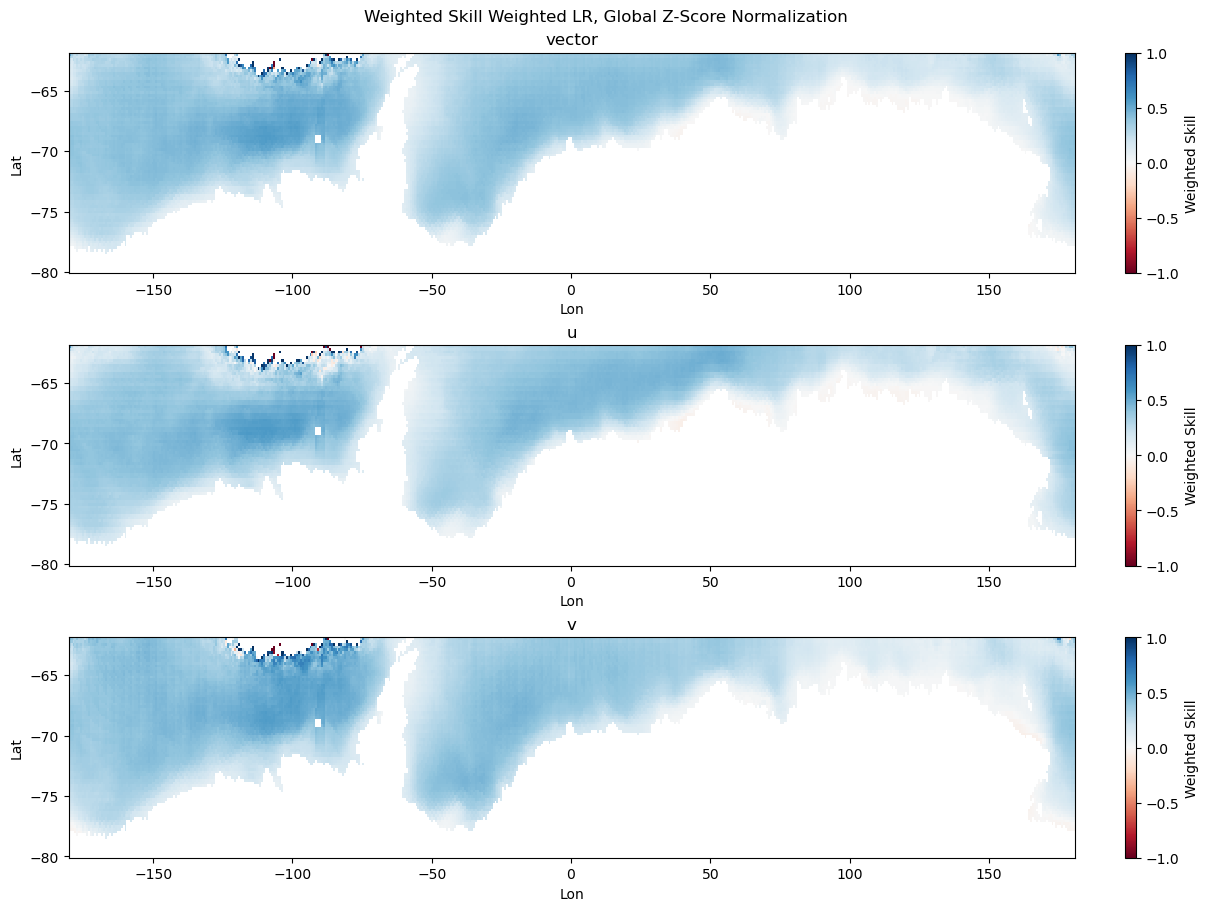

/tmp/ipykernel_2236790/1007861887.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_vector = np.nanvar(true, axis = 0)
/tmp/ipykernel_2236790/1007861887.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_true_u = np.nanvar(np.real(true), axis = 0)


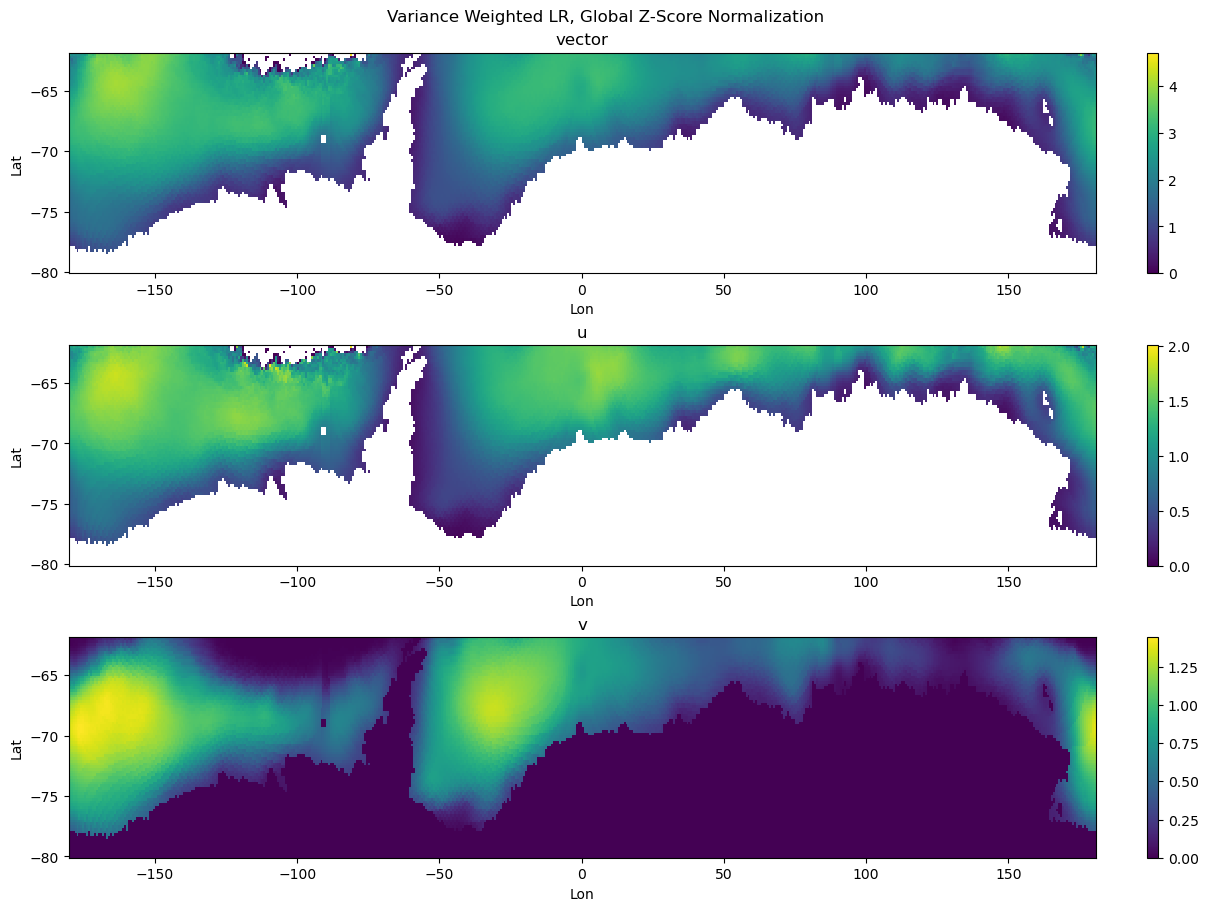

In [67]:
wlrgz_skill_z, wlrgz_skill_u, wlrgz_skill_v, wlrgz_w_skill_z, wlrgz_w_skill_u, wlrgz_w_skill_v = return_plot_skill(fit_all_gz, true_all_gz, rt_n, 'Weighted LR, Global Z-Score Normalization')

# Without 'Sparse Diagonal' for R

/tmp/ipykernel_2236790/2020770005.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varvals_norm[i,:,:] = np.nanvar(normval, axis = 0)
/tmp/ipykernel_2236790/2020770005.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  pcm = axs[i].pcolormesh(lon, lat, np.nanvar(data[i], axis = 0))


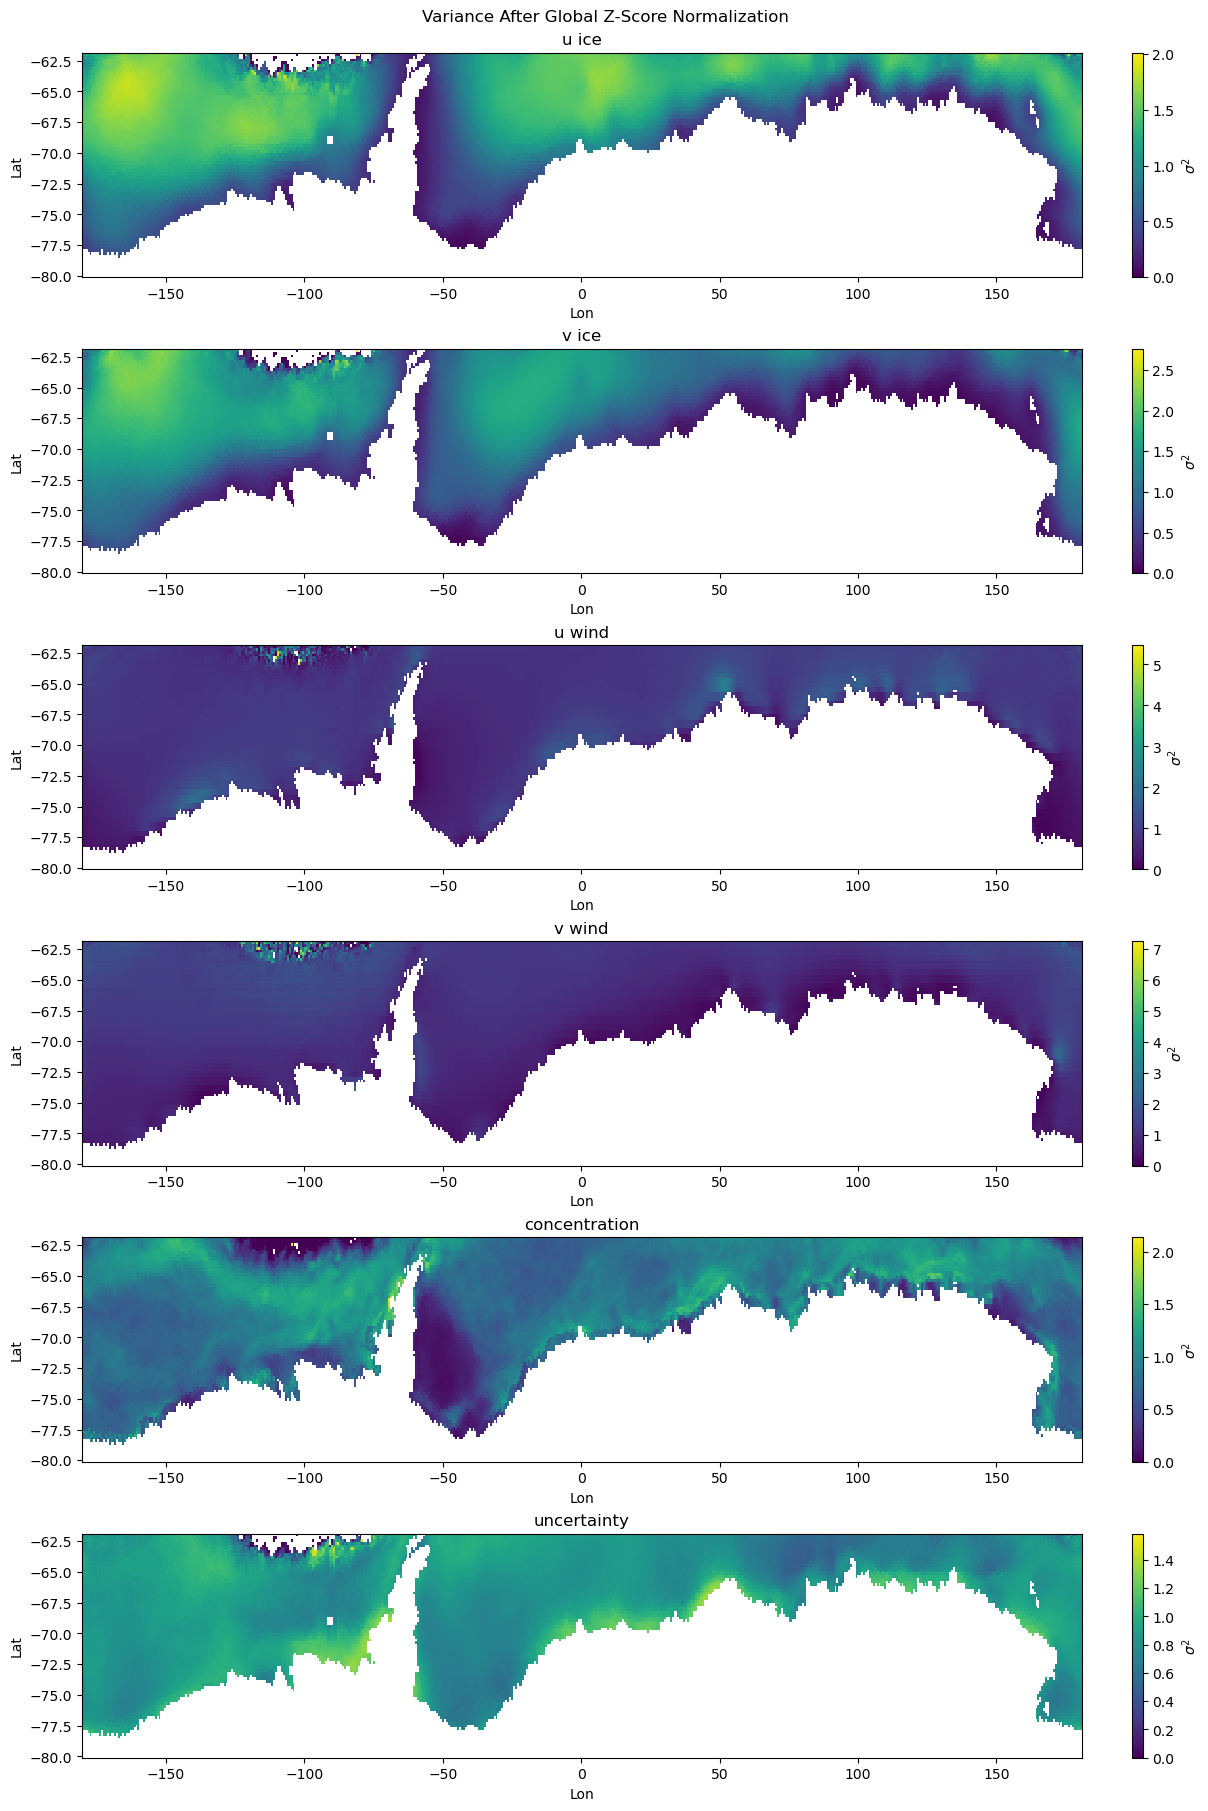

In [68]:
data = [uit_n, vit_n, uwt_n, vwt_n, icy_n, rt_n]

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, 3*nd), constrained_layout=True)
titles = ['u ice', 'v ice', 'u wind', 'v wind', 'concentration', 'uncertainty']

for i in range(nd):
    
    varvals_norm[i,:,:] = np.nanvar(normval, axis = 0)
    
    pcm = axs[i].pcolormesh(lon, lat, np.nanvar(data[i], axis = 0))
    fig.colorbar(pcm, ax=axs[i], label=r'$ \sigma^2 $')
    axs[i].set(title=titles[i], xlabel='Lon', ylabel='Lat')
    
fig.suptitle('Variance After Global Z-Score Normalization')

plt.show()

In [70]:
def lr_weighted_gridwise_gz_slow(uit_n, vit_n, uwt_n, vwt_n, icy_n, rt_n, gstds, epsilon):
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit_n)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)
    rt_n_all = np.full((nt, ny, nx), np.nan)
    
    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit_n[:,iy,ix]), np.isnan(vit_n[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit_n[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit_n[:,iy,ix]), np.isnan(vit_n[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit_n[true_mask, iy, ix]
                    vit_f = vit_n[true_mask, iy, ix]
                    uwt_f = uwt_n[true_mask, iy, ix]
                    vwt_f = vwt_n[true_mask, iy, ix]
                    icy_f = icy_n[true_mask, iy, ix]
                    rt_f = rt_n[true_mask, iy, ix]


                    # Convert to complex
                    it_c = uit_f + vit_f*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_f + vwt_f*1j # Complex 'today' wind vector
                    icy_c = icy_f + icy_f*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T
                    
                    rr = 2 * ((rt_f ** 2) + epsilon)
                    rr = 1 / rr

                    # Create diagonal matrix of uncertainty
                    R = np.diag(rr)

                    # Weighted model parameters
                    m = (LA.inv((G.conj().T @ R @ G))) @ G.conj().T @ R @ d # (adapted from eqn 39, SIOC221B Lec 10)

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all, rt_n_all

In [ ]:
m_gzslow, fit_gzslow, true_gzslow, rt_n_gzslow = lr_weighted_gridwise_gz_slow(uit_n, vit_n, uwt_n, vwt_n, icy_n, rt_n, gstds, 0.001)

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete


In [ ]:
wlrgzslow_skill_z, wlrgzslow_skill_u, wlrgzslow_skill_v, wlrgzslow_w_skill_z, wlrgzslow_w_skill_u, wlrgzslow_w_skill_v = return_plot_skill(fit_gzslow, true_gzslow, rt_n, 'Weighted LR, Global Z-Score Normalization, Slow Diagonal')

In [ ]:
# TODO: Remove mean GRIDWISE, then Normalize by Global STD